In [ ]:
#Load all necessary libraries 
library(spacexr)
library(Matrix)
library(Seurat)
library(SeuratData)
library(SeuratDisk)
library(ggplot2)
library(patchwork)
library(dplyr)
library(tidyverse)
library(RCTD)
library(Matrix)
library(Seurat)
library(tidyverse)
library(RColorBrewer)
library(doParallel)
library(dittoSeq)
library(ggsci)

In [3]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] doParallel_1.0.17         iterators_1.0.14         
 [3] foreach_1.5.2             RColorBrewer_1.1-3       
 [5] RCTD_2.0.0                forcats_0.5.2            
 [7] stringr_1.4.1             purrr_0.3.4              
 [9] readr_2.1.2               tidyr_1.2.1              
[11] tibble_3.1.8          

## Load and format single cell reference dataset 

In [16]:
## Load single cell reference 

setwd("/home/vshanmug/results/091122_detailed_single_nuc_Hodgkin_annotation_exploration/")

ref <- LoadH5Seurat("combined_dataset_final_annotated_postqc_harmonized1.h5Seurat")

Validating h5Seurat file

Initializing cellbender_corrected with data

Adding counts for cellbender_corrected

Adding feature-level metadata for cellbender_corrected

Adding variable feature information for cellbender_corrected

Adding miscellaneous information for cellbender_corrected

Adding reduction harmony

Adding cell embeddings for harmony

Adding feature loadings for harmony

Adding projected loadings for harmony

Adding miscellaneous information for harmony

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



In [17]:
## Create single cell ref 

RLN_ref <- subset(ref, subset = condition == "RLN")
HL_ref <- subset(ref, subset = condition == "HL")

counts_RLN <- RLN_ref@assays$cellbender_corrected@counts
cell_types_RLN <- as.factor(RLN_ref$cell_types_level_3)

RLN_ref <- Reference(counts_RLN, cell_types_RLN)

counts_HL <- HL_ref@assays$cellbender_corrected@counts
cell_types_HL <- as.factor(HL_ref$cell_types_level_3)

HL_ref <- Reference(counts_HL, cell_types_HL)


Warning message in Reference(counts_RLN, cell_types_RLN):
“Reference: number of cells per cell type is 39957, larger than maximum allowable of 10000. Downsampling number of cells to: 10000”
Warning message in Reference(counts_HL, cell_types_HL):
“Reference: number of cells per cell type is 91210, larger than maximum allowable of 10000. Downsampling number of cells to: 10000”


In [18]:
## save reference object 
setwd("/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/")

saveRDS(RLN_ref, "snref_new_RLN_RCTD.rds")
saveRDS(HL_ref, "snref_new_HL_RCTD.rds")

## Load all spatial data 

In [47]:
# Create all relevant functions needed for the rest of this notebook 

## Loop download multiple spatialRNA replicate objects from a google bucket given a character vector of replicate names and create a named list

download_spatialRNA_objects <- function(puck_names){
    puck_list <- list()
for (i in 1:length(puck_names)){
    system(paste0("gsutil -m cp gs://lymphoma-slideseq-data-broad/results/processed_slideseq_data/", puck_names[i], "/processed/spatialRNA.rds", " /home/vshanmug/data"))
    puck_list[[i]] <- readRDS("/home/vshanmug/data/spatialRNA.rds")
    system(paste0("rm /home/vshanmug/data/spatialRNA.rds"))
    print(paste0("Completed loading replicate ", i))
}
    names(puck_list) <- puck_names
    return(puck_list)
}

## Function to create all RCTD plots for a given vector of puck names 

create_RCTD_plots_all <- function(RCTD_replicates, puck_names, datadir, folder_name_suffix) {
    for(i in 1:length(puck_names)){
        results <- RCTD_replicates@RCTD.reps[[i]]@results
        norm_weights = sweep(results$weights, 1, rowSums(results$weights), '/')
        cell_type_names <- RCTD_replicates@RCTD.reps[[i]]@cell_type_info$info[[2]] #list of cell type names
        spatialRNA <- RCTD_replicates@RCTD.reps[[i]]@spatialRNA
        resultsdir <- file.path(datadir, paste0(puck_names[i], folder_name_suffix)) ## you may change this to a more accessible directory on your computer.
        if(!dir.exists(resultsdir))
            dir.create(resultsdir)
        plot_weights(cell_type_names, spatialRNA, resultsdir, norm_weights) # Plots all weights for each cell type as in full_mode. (saved as 'results/cell_type_weights.pdf')
        plot_weights_unthreshold(cell_type_names, spatialRNA, resultsdir, norm_weights) 
        plot_weights_doublet(cell_type_names, spatialRNA, resultsdir, results$weights_doublet, results$results_df) # Plots the weights for each cell type as in doublet_mode. (saved as 'results/cell_type_weights_doublets.pdf')
        plot_cond_occur(cell_type_names, resultsdir, norm_weights, spatialRNA) # Plots the number of confident pixels of each cell type in 'full_mode'. (saved as 'results/cell_type_occur.pdf')
        plot_all_cell_types(results$results_df, spatialRNA@coords, cell_type_names, resultsdir) # makes a map of all cell types, (saved as 'results/all_cell_types.pdf')
        }
}

In [7]:
## This code chunk creates a named list of all spatialRNA objects of reactive LN samples 
## Create a character vector with names of all replicates 
puck_ids <- c("2020-12-12_Puck_201014_05", "2020-12-12_Puck_201014_06", "2021-04-14_Puck_210119_21", "2021-04-14_Puck_210119_22", "2021-11-29_Puck_211018_21", "2021-11-29_Puck_211018_23", "2021-09-30_Puck_210824_14", "2021-09-30_Puck_210824_15", "2021-11-29_Puck_211022_02", "2021-11-29_Puck_211022_03", "2021-11-29_Puck_210810_23", "2021-11-29_Puck_210810_24", "2021-09-30_Puck_210824_17", "2021-11-29_Puck_210731_11", "2021-11-29_Puck_210731_12", "2021-11-29_Puck_210731_13", "2021-09-30_Puck_210824_19", "2021-09-30_Puck_210824_20", "2021-11-29_Puck_210720_27", "2021-11-29_Puck_210720_28", "2021-11-29_Puck_210720_29", "2021-10-08_Puck_210910_27", "2021-11-29_Puck_211008_39", "2021-11-29_Puck_211018_01")

## Create group_ids for each of the replicate i.e. group replicates by sample
group_ids <- c(1, 1, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7); names(group_ids) <- puck_ids

## The above 2 vectors are needed for the create.RCTD.replicates function that will be used later to create an integrated RCTD object

## Loop download all RCTD objects from bucket to create a list of all replicates
puck_list <- download_spatialRNA_objects(puck_names = puck_ids)

[1] "Completed loading replicate 1"
[1] "Completed loading replicate 2"
[1] "Completed loading replicate 3"
[1] "Completed loading replicate 4"
[1] "Completed loading replicate 5"
[1] "Completed loading replicate 6"
[1] "Completed loading replicate 7"
[1] "Completed loading replicate 8"
[1] "Completed loading replicate 9"
[1] "Completed loading replicate 10"
[1] "Completed loading replicate 11"
[1] "Completed loading replicate 12"
[1] "Completed loading replicate 13"
[1] "Completed loading replicate 14"
[1] "Completed loading replicate 15"
[1] "Completed loading replicate 16"
[1] "Completed loading replicate 17"
[1] "Completed loading replicate 18"
[1] "Completed loading replicate 19"
[1] "Completed loading replicate 20"
[1] "Completed loading replicate 21"
[1] "Completed loading replicate 22"
[1] "Completed loading replicate 23"
[1] "Completed loading replicate 24"


## Create combined RCTD replicates object and run RCTD

In [48]:
##Load reference data 

setwd("/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/")

RLN_ref <- readRDS("snref_new_RLN_RCTD.rds")
HL_ref <- readRDS("snref_new_HL_RCTD.rds")

## This code chunk creates a named list of all spatialRNA objects of reactive LN samples 
## Create a character vector with names of all replicates 
puck_ids_RLN <- c("2020-12-12_Puck_201014_05", "2020-12-12_Puck_201014_06", "2021-04-14_Puck_210119_21", "2021-04-14_Puck_210119_22", "2021-11-29_Puck_211018_21", "2021-11-29_Puck_211018_23", "2021-09-30_Puck_210824_14", "2021-09-30_Puck_210824_15", "2021-11-29_Puck_211022_02", "2021-11-29_Puck_211022_03", "2021-11-29_Puck_210810_23", "2021-11-29_Puck_210810_24", "2021-09-30_Puck_210824_17", "2021-11-29_Puck_210731_11", "2021-11-29_Puck_210731_12", "2021-11-29_Puck_210731_13", "2021-09-30_Puck_210824_19", "2021-09-30_Puck_210824_20", "2021-11-29_Puck_210720_27", "2021-11-29_Puck_210720_28", "2021-11-29_Puck_210720_29", "2021-10-08_Puck_210910_27", "2021-11-29_Puck_211008_39", "2021-11-29_Puck_211018_01")

## Create group_ids for each of the replicate i.e. group replicates by sample
group_ids_RLN <- c(1, 1, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7); names(group_ids_RLN) <- puck_ids_RLN

## The above 2 vectors are needed for the create.RCTD.replicates function that will be used later to create an integrated RCTD object

## Loop download all RCTD objects from bucket to create a list of all replicates
puck_list_RLN <- download_spatialRNA_objects(puck_names = puck_ids_RLN)

[1] "Completed loading replicate 1"
[1] "Completed loading replicate 2"
[1] "Completed loading replicate 3"
[1] "Completed loading replicate 4"
[1] "Completed loading replicate 5"
[1] "Completed loading replicate 6"
[1] "Completed loading replicate 7"
[1] "Completed loading replicate 8"
[1] "Completed loading replicate 9"
[1] "Completed loading replicate 10"
[1] "Completed loading replicate 11"
[1] "Completed loading replicate 12"
[1] "Completed loading replicate 13"
[1] "Completed loading replicate 14"
[1] "Completed loading replicate 15"
[1] "Completed loading replicate 16"
[1] "Completed loading replicate 17"
[1] "Completed loading replicate 18"
[1] "Completed loading replicate 19"
[1] "Completed loading replicate 20"
[1] "Completed loading replicate 21"
[1] "Completed loading replicate 22"
[1] "Completed loading replicate 23"
[1] "Completed loading replicate 24"


In [52]:
## Recreate RCTD object for RLN samples with ther 'T_other' cell type excluded 
## Replace previous outputs with these results 

cell_types_rest <- levels(RLN_ref@cell_types)[levels(RLN_ref@cell_types) != "T_other"]
cell_types_rest

RLN.RCTD.combined <- create.RCTD.replicates(spatialRNA.replicates = puck_list_RLN, reference = RLN_ref, replicate_names = puck_ids_RLN, group_ids = group_ids_RLN, cell_type_names = cell_types_rest, max_cores = 52)

[1] "B_cells"      "BEC"          "CD4_T_cells"  "CD8_T_cells"  "FDC"         
 [6] "Fibroblasts"  "LEC"          "Macrophages"  "mDC"          "Monocytes"   
[11] "NK_cells"     "pDC"          "Plasma_cells"

[1] "Begin: process_cell_type_info"
[1] "process_cell_type_info: number of cells in reference: 42893"
[1] "process_cell_type_info: number of genes in reference: 29786"

     B_cells          BEC  CD4_T_cells  CD8_T_cells          FDC  Fibroblasts 
       10000          261        10000        10000          376         2649 
         LEC  Macrophages          mDC    Monocytes     NK_cells          pDC 
         670         2237         1837          365          524         1100 
Plasma_cells      T_other 
        1569         1305 
[1] "End: process_cell_type_info"
[1] "create.RCTD.replicates: creating RCTD for replicate 1"
[1] "create.RCTD: getting regression differentially expressed genes: "
[1] "get_de_genes: B_cells found DE genes: 195"
[1] "get_de_genes: BEC found DE genes: 255"
[1] "get_de_genes: CD4_T_cells found DE genes: 166"
[1] "get_de_genes: CD8_T_cells found DE genes: 185"
[1] "get_de_genes: FDC found DE genes: 322"
[1] "get_de_genes: Fibroblasts found DE genes: 379"
[1] 

In [53]:
## Create a version of the RCTD object with cell type classes 

RLN.RCTD.combined.with.class <- RLN.RCTD.combined
for(i in 1:length(puck_ids_RLN)){
    class_df <- RLN.RCTD.combined.with.class@RCTD.reps[[i]]@internal_vars$class_df
    class_df[c(3,4),1] <- "T_cells"
    class_df[c(5,6),1] <- "stromal" 
    class_df[c(2,7),1] <- "vascular"
    class_df[c(8,9,10),1] <- "myeloid"
    RLN.RCTD.combined.with.class@RCTD.reps[[i]]@internal_vars$class_df <- class_df
}

RLN.RCTD.combined.with.class@RCTD.reps[[3]]@internal_vars$class_df

class       
B_cells      B_cells     
BEC          vascular    
CD4_T_cells  T_cells     
CD8_T_cells  T_cells     
FDC          stromal     
Fibroblasts  stromal     
LEC          vascular    
Macrophages  myeloid     
mDC          myeloid     
Monocytes    myeloid     
NK_cells     NK_cells    
pDC          pDC         
Plasma_cells Plasma_cells

In [54]:
## Run RCTD with cell type class information 

RLN.RCTD.combined.with.class <- run.RCTD.replicates(RCTD.replicates = RLN.RCTD.combined.with.class, doublet_mode = "doublet")

saveRDS(RLN.RCTD.combined.with.class, "/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/RLN_RCTD_combined_with_class_new_snref.rds")

system(paste0("gsutil -m cp /home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/RLN_RCTD_combined_with_class_new_snref.rds", " gs://lymphoma-slideseq-data-broad/results/processed_slideseq_data/"))



[1] "run.RCTD.replicates: running RCTD for replicate 1"
[1] "fitBulk: decomposing bulk"
[1] "chooseSigma: using initial Q_mat with sigma =  1"
[1] "Likelihood value: 437076.109522086"
[1] "Sigma value:  0.84"
[1] "Likelihood value: 434089.096551523"
[1] "Sigma value:  0.69"
[1] "Likelihood value: 432076.941499751"
[1] "Sigma value:  0.61"
[1] "Likelihood value: 431323.508203803"
[1] "Sigma value:  0.53"
[1] "Likelihood value: 430788.090832807"
[1] "Sigma value:  0.46"
[1] "Likelihood value: 430489.988032575"
[1] "Sigma value:  0.41"
[1] "Likelihood value: 430367.748926963"
[1] "Sigma value:  0.37"
[1] "Likelihood value: 430319.886305842"
[1] "Sigma value:  0.36"
[1] "gather_results: finished 1000"
[1] "gather_results: finished 2000"
[1] "gather_results: finished 3000"
[1] "gather_results: finished 4000"
[1] "gather_results: finished 5000"
[1] "gather_results: finished 6000"
[1] "gather_results: finished 7000"
[1] "gather_results: finished 8000"
[1] "gather_results: finished 9000"
[1] "

ERROR: Error in create_RCTD_plots_all(RCTD_replicates = RLN.RCTD.combined.with.class, : object 'puck_ids' not found


In [61]:
# Generate all RCTD plots 

create_RCTD_plots_all(RCTD_replicates = RLN.RCTD.combined.with.class, puck_names = puck_ids_RLN, datadir = "/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/", folder_name_suffix = "_RCTD_Plots_with_class_without_T_other")

In [56]:
## Repeat the same for the CHL samples 

## Create replicate name list in order - character vector
puck_ids_CHL <- c("2020-12-12_Puck_201014_03", "2020-12-12_Puck_201014_04", "2021-11-29_Puck_211018_32", "2021-11-29_Puck_211018_38", "2021-11-11_Puck_210910_04", "2021-11-11_Puck_210910_03", "2021-11-29_Puck_211018_28", "2021-11-29_Puck_211018_31", "2021-11-11_Puck_210910_05", "2021-11-11_Puck_210910_06", "2020-12-22_Puck_200827_12", "2021-01-20_Puck_200906_25", "2021-10-16_Puck_210910_01", "2021-10-16_Puck_210910_02", "2021-11-29_Puck_211018_18", "2021-11-29_Puck_211018_19", "2021-11-29_Puck_211018_26", "2021-11-29_Puck_211018_27", "2021-11-11_Puck_210910_07", "2021-11-11_Puck_210910_09", "2021-11-29_Puck_211018_29", "2021-11-29_Puck_211018_24", "2021-11-13_Puck_211008_08", "2021-11-29_Puck_211008_34", "2021-11-29_Puck_211008_38", "2021-11-13_Puck_211008_09", "2021-11-29_Puck_211018_04", "2021-11-29_Puck_211018_07", "2021-11-13_Puck_211008_06", "2021-11-29_Puck_211008_27", "2021-11-29_Puck_211008_28", "2021-11-29_Puck_211008_32", "2021-11-13_Puck_211004_39", "2021-11-29_Puck_211018_02", "2021-11-29_Puck_211018_03", "2021-11-13_Puck_211008_07", "2021-11-29_Puck_211018_17", "2021-11-13_Puck_211008_03")

## Create group_ids replicate named integer vector
group_ids_CHL <- c(8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 19, 19); names(group_ids_CHL) <- puck_ids_CHL

## The above 2 vectors are needed for the create.RCTD.replicates function that will be used later to create an integrated RCTD object

## Loop download all RCTD objects from bucket to create a list of all replicates
puck_list_CHL <- download_spatialRNA_objects(puck_names = puck_ids_CHL)

[1] "Completed loading replicate 1"
[1] "Completed loading replicate 2"
[1] "Completed loading replicate 3"
[1] "Completed loading replicate 4"
[1] "Completed loading replicate 5"
[1] "Completed loading replicate 6"
[1] "Completed loading replicate 7"
[1] "Completed loading replicate 8"
[1] "Completed loading replicate 9"
[1] "Completed loading replicate 10"
[1] "Completed loading replicate 11"
[1] "Completed loading replicate 12"
[1] "Completed loading replicate 13"
[1] "Completed loading replicate 14"
[1] "Completed loading replicate 15"
[1] "Completed loading replicate 16"
[1] "Completed loading replicate 17"
[1] "Completed loading replicate 18"
[1] "Completed loading replicate 19"
[1] "Completed loading replicate 20"
[1] "Completed loading replicate 21"
[1] "Completed loading replicate 22"
[1] "Completed loading replicate 23"
[1] "Completed loading replicate 24"
[1] "Completed loading replicate 25"
[1] "Completed loading replicate 26"
[1] "Completed loading replicate 27"
[1] "Compl

In [59]:
## Create combined RCTD object 

cell_types_rest <- levels(HL_ref@cell_types)[levels(HL_ref@cell_types) != "T_other"]
cell_types_rest

CHL.RCTD.combined <- create.RCTD.replicates(spatialRNA.replicates = puck_list_CHL, reference = HL_ref, cell_type_names = cell_types_rest, replicate_names = puck_ids_CHL, group_ids = group_ids_CHL, max_cores = 52)

[1] "B_cells"      "BEC"          "CD4_T_cells"  "CD8_T_cells"  "FDC"         
 [6] "Fibroblasts"  "LEC"          "Macrophages"  "mDC"          "Monocytes"   
[11] "NK_cells"     "pDC"          "Plasma_cells" "Tumor"

[1] "Begin: process_cell_type_info"
[1] "process_cell_type_info: number of cells in reference: 83051"
[1] "process_cell_type_info: number of genes in reference: 29786"

     B_cells          BEC  CD4_T_cells  CD8_T_cells          FDC  Fibroblasts 
       10000         1717        10000        10000         1454        10000 
         LEC  Macrophages          mDC    Monocytes     NK_cells          pDC 
        1857        10000         6142         3547         2229         2224 
Plasma_cells      T_other        Tumor 
        6653          508         6720 
[1] "End: process_cell_type_info"
[1] "create.RCTD.replicates: creating RCTD for replicate 1"
[1] "create.RCTD: getting regression differentially expressed genes: "
[1] "get_de_genes: B_cells found DE genes: 202"
[1] "get_de_genes: BEC found DE genes: 312"
[1] "get_de_genes: CD4_T_cells found DE genes: 188"
[1] "get_de_genes: CD8_T_cells found DE genes: 201"
[1] "get_de_genes: FDC found DE genes: 315"
[1] "get_de_genes: Fibroblasts

In [60]:
## Create a version of the RCTD object with cell type classes 

CHL.RCTD.combined.with.class <- CHL.RCTD.combined
for(i in 1:length(puck_ids_CHL)){
    class_df <- CHL.RCTD.combined.with.class@RCTD.reps[[i]]@internal_vars$class_df
    class_df[c(3,4),1] <- "T_cells"
    class_df[c(5,6),1] <- "stromal" 
    class_df[c(2,7),1] <- "vascular"
    class_df[c(8,9,10),1] <- "myeloid"
    CHL.RCTD.combined.with.class@RCTD.reps[[i]]@internal_vars$class_df <- class_df
}

CHL.RCTD.combined.with.class@RCTD.reps[[3]]@internal_vars$class_df

class       
B_cells      B_cells     
BEC          vascular    
CD4_T_cells  T_cells     
CD8_T_cells  T_cells     
FDC          stromal     
Fibroblasts  stromal     
LEC          vascular    
Macrophages  myeloid     
mDC          myeloid     
Monocytes    myeloid     
NK_cells     NK_cells    
pDC          pDC         
Plasma_cells Plasma_cells
Tumor        Tumor

In [ ]:
## Run RCTD with cell type class information 

CHL.RCTD.combined.with.class <- run.RCTD.replicates(RCTD.replicates = CHL.RCTD.combined.with.class, doublet_mode = "doublet")

saveRDS(CHL.RCTD.combined.with.class, "/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/CHL_RCTD_combined_with_class_new_snref.rds")

system(paste0("gsutil -m cp /home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/CHL_RCTD_combined_with_class_new_snref.rds", " gs://lymphoma-slideseq-data-broad/results/processed_slideseq_data/"))

# Generate all RCTD plots 
create_RCTD_plots_all(RCTD_replicates = CHL.RCTD.combined.with.class, puck_names = puck_ids_CHL, datadir = "/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/", folder_name_suffix = "_RCTD_Plots_with_class_without_T_other")

In [37]:
## Generate df of all cell type assignments

RCTD_results_df <- function(RCTD_replicates){
    df_list <- list()
    for(i in 1:length(RCTD_replicates@RCTD.reps)){
        results_df <- RCTD_replicates@RCTD.reps[[i]]@results$results_df %>% rownames_to_column(var = "barcode")
        df_list[[i]] <- results_df  
    }
    sample_groups <- stack(RCTD_replicates@group_ids)
    colnames(sample_groups) <- c("groups", "puck_names")
    names(df_list) <- sample_groups$puck_names
    df <- bind_rows(df_list, .id = "puck_names")
    df <- df %>% left_join(sample_groups, by = "puck_names")
    return(df)
}

RLN_results <- RCTD_results_df(RLN.RCTD.combined.with.class)

CHL_results <- RCTD_results_df(CHL.RCTD.combined.with.class)

RLN_results$sample_type <- "Reactive"
CHL_results$sample_type <- "Hodgkin lymphoma"

results_df <- rbind(RLN_results, CHL_results)

head(results_df)

In [47]:
##Save as csv file 
setwd("/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/")

write.csv(results_df, "slideseq_RCTD_results_combined_new_snref.csv")

## Visualization of results 

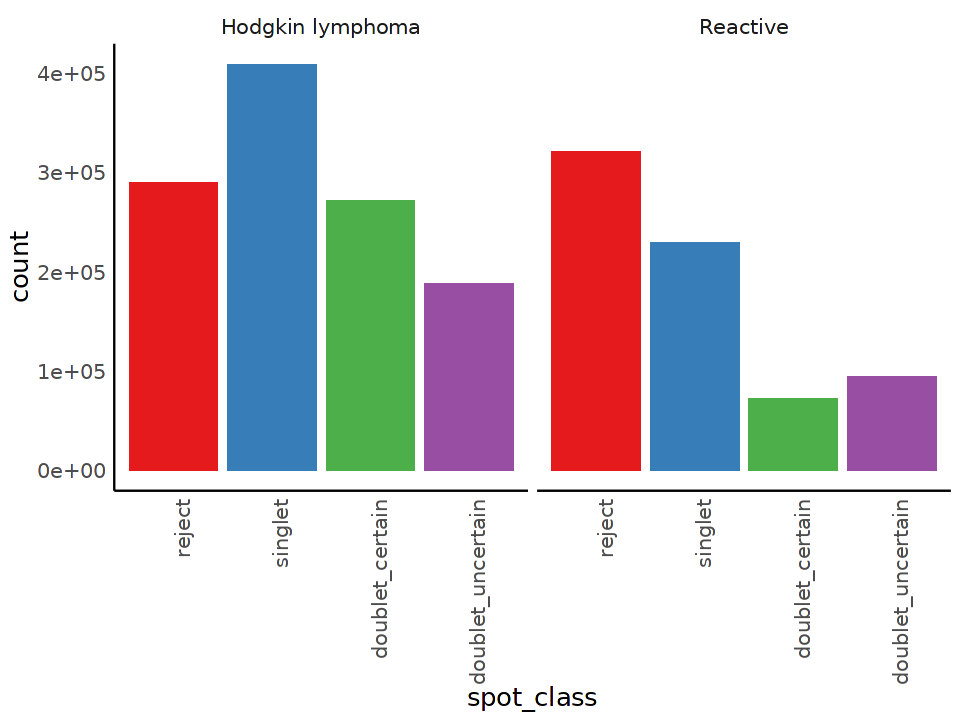

In [46]:
##Plot histogram of reject rates 

options(repr.plot.width=8, repr.plot.height=6)

ggplot(results_df, aes(x = spot_class, fill = spot_class)) +
geom_bar() + 
theme_minimal() +
theme(text = element_text(size = 15), axis.text.x = element_text(angle = 90, vjust = 1.1, hjust=1), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) + NoLegend() + 
scale_fill_brewer(palette = "Set1") +
facet_grid(. ~ sample_type)

In [48]:
results_df_long <- results_df %>% pivot_longer(cols = c(first_type, second_type), names_to = "cell_type_order", values_to = "cell_type")
results_ct_first_type <- results_df_long %>% filter(spot_class %in% c("singlet", "doublet_uncertain")) %>% filter(cell_type_order %in% c("first_type"))
results_ct_doublets <- results_df_long %>% filter(spot_class %in% c("doublet_certain"))
results_ct_combined <- bind_rows(results_ct_first_type, results_ct_doublets)
ct_freq <- results_ct_combined %>% select(sample_type, cell_type) %>% group_by(sample_type, cell_type) %>% summarize(number = n())
condition_sum <- ct_freq %>% group_by(sample_type) %>% summarize(sum = sum(number))
ct_freq <- ct_freq %>% left_join(condition_sum, by = "sample_type") %>% mutate(pct = (number/sum)*100)
ct_freq$sample_type <- factor(ct_freq$sample_type, levels = c("Reactive", "Hodgkin lymphoma"))

puck_names                barcode          spot_class       
1       2020-12-12_Puck_201014_05 AACAGCTTGTTAAG   doublet_certain  
2       2020-12-12_Puck_201014_05 AACAGCTTGTTAAG   doublet_certain  
3       2020-12-12_Puck_201014_05 AAAGCCAGAATGAC   doublet_certain  
4       2020-12-12_Puck_201014_05 AAAGCCAGAATGAC   doublet_certain  
5       2020-12-12_Puck_201014_05 TCAAGCCCCACCAG   doublet_certain  
6       2020-12-12_Puck_201014_05 TCAAGCCCCACCAG   doublet_certain  
7       2020-12-12_Puck_201014_05 TCTCCACTACTGGA   doublet_certain  
8       2020-12-12_Puck_201014_05 TCTCCACTACTGGA   doublet_certain  
9       2020-12-12_Puck_201014_05 TCCTAATASCAATY   doublet_certain  
10      2020-12-12_Puck_201014_05 TCCTAATASCAATY   doublet_certain  
11      2020-12-12_Puck_201014_05 ATACGACACGTGGC   doublet_uncertain
12      2020-12-12_Puck_201014_05 ATACGACACGTGGC   doublet_uncertain
13      2020-12-12_Puck_201014_05 ATTGGAACCAAAGG   doublet_uncertain
14      2020-12-12_Puck_201014_05 ATTGGAACCAAAGG   doublet_uncertain
15      2020-12-12_Puck_201014_05 CTAATTTCTACTCT   doublet_certain  
16      2020-12-12_Puck_201014_05 CTAATTTCTACTCT   doublet_certain  
17      2020-12-12_Puck_201014_05 GAAGCCCTGATAGT   doublet_certain  
18      2020-12-12_Puck_201014_05 GAAGCCCTGATAGT   doublet_certain  
19      2020-12-12_Puck_201014_05 TGAAGTTTTAGTAG   doublet_uncertain
20      2020-12-12_Puck_201014_05 TGAAGTTTTAGTAG   doublet_uncertain
21      2020-12-12_Puck_201014_05 AAACCCAGCTCGAG   doublet_certain  
22      2020-12-12_Puck_201014_05 AAACCCAGCTCGAG   doublet_certain  
23      2020-12-12_Puck_201014_05 AGACCGAAAGGTCG   doublet_certain  
24      2020-12-12_Puck_201014_05 AGACCGAAAGGTCG   doublet_certain  
25      2020-12-12_Puck_201014_05 TTCCATGACCTAGA   doublet_uncertain
26      2020-12-12_Puck_201014_05 TTCCATGACCTAGA   doublet_uncertain
27      2020-12-12_Puck_201014_05 ACACTTCTACACGA   doublet_certain  
28      2020-12-12_Puck_201014_05 ACACTTCTACACGA   doublet_certain  
29      2020-12-12_Puck_201014_05 TCGGTCGGSAGATC   doublet_uncertain
30      2020-12-12_Puck_201014_05 TCGGTCGGSAGATC   doublet_uncertain
⋮       ⋮                         ⋮                ⋮                
3758725 2021-11-13_Puck_211008_03 GTACTGTACCTTGC-1 reject           
3758726 2021-11-13_Puck_211008_03 GTACTGTACCTTGC-1 reject           
3758727 2021-11-13_Puck_211008_03 TCAGTCAGCATGGT-1 singlet          
3758728 2021-11-13_Puck_211008_03 TCAGTCAGCATGGT-1 singlet          
3758729 2021-11-13_Puck_211008_03 TTGGACCTTTTCCA-1 singlet          
3758730 2021-11-13_Puck_211008_03 TTGGACCTTTTCCA-1 singlet          
3758731 2021-11-13_Puck_211008_03 CTGATTTCAAGCGA-1 singlet          
3758732 2021-11-13_Puck_211008_03 CTGATTTCAAGCGA-1 singlet          
3758733 2021-11-13_Puck_211008_03 AACCAGTCGATACA-1 singlet          
3758734 2021-11-13_Puck_211008_03 AACCAGTCGATACA-1 singlet          
3758735 2021-11-13_Puck_211008_03 CTGGACAGTGAATG-1 singlet          
3758736 2021-11-13_Puck_211008_03 CTGGACAGTGAATG-1 singlet          
3758737 2021-11-13_Puck_211008_03 AGAGAGTTGTGCCT-1 singlet          
3758738 2021-11-13_Puck_211008_03 AGAGAGTTGTGCCT-1 singlet          
3758739 2021-11-13_Puck_211008_03 CCCGCCGAGACGCC-1 singlet          
3758740 2021-11-13_Puck_211008_03 CCCGCCGAGACGCC-1 singlet          
3758741 2021-11-13_Puck_211008_03 TCACCCGGACGTAT-1 doublet_certain  
3758742 2021-11-13_Puck_211008_03 TCACCCGGACGTAT-1 doublet_certain  
3758743 2021-11-13_Puck_211008_03 GTTACAATTGTGAG-1 singlet          
3758744 2021-11-13_Puck_211008_03 GTTACAATTGTGAG-1 singlet          
3758745 2021-11-13_Puck_211008_03 CACTACCAACCATT-1 reject           
3758746 2021-11-13_Puck_211008_03 CACTACCAACCATT-1 reject           
3758747 2021-11-13_Puck_211008_03 ATTAAAAGTAAGAC-1 singlet          
3758748 2021-11-13_Puck_211008_03 ATTAAAAGTAAGAC-1 singlet          
3758749 2021-11-13_Puck_211008_03 CCATCGCTCATGTG-1 singlet          
3758750 2021-11-13_Puck_211008_03 CCATCGCTCATGTG-1 singlet          
375875

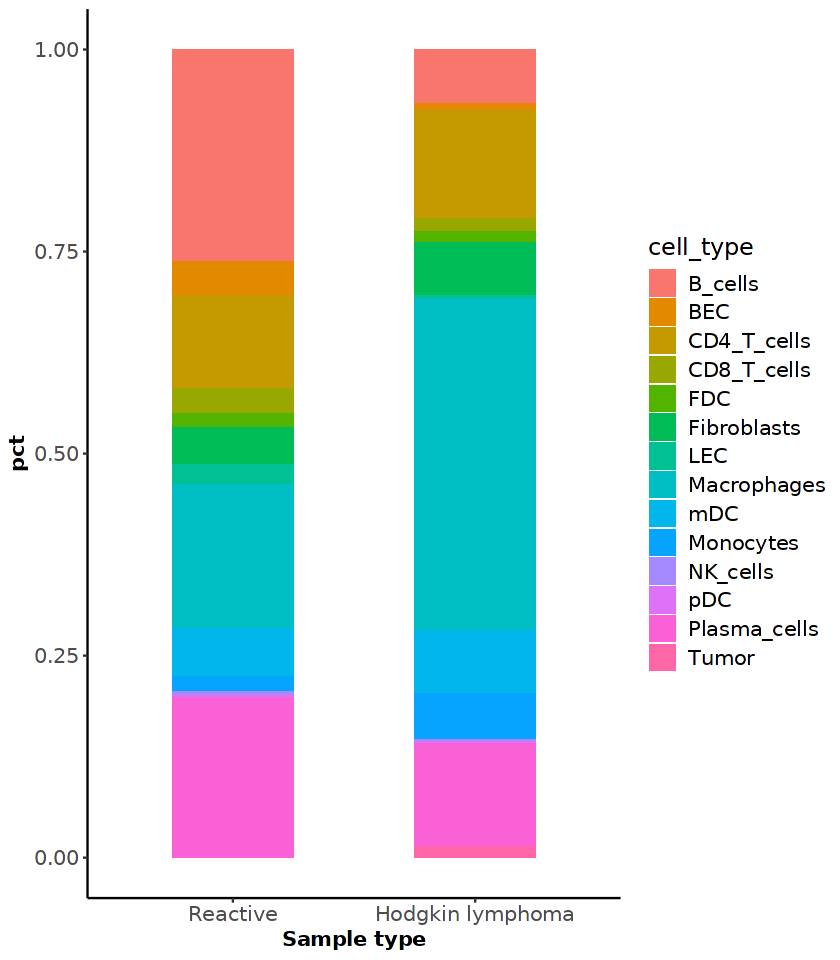

In [33]:
## Stacked barplot of cell type frequencies 

options(repr.plot.width=7, repr.plot.height=8)

ggplot(ct_freq, aes(x = sample_type, y = pct, fill = cell_type)) +
    geom_bar(position = "fill", stat="identity", width = 0.5) + 
    theme_classic() +
    #scale_fill_brewer(palette = "Dark2") +
    xlab("Sample type") + 
    theme(axis.text=element_text(size=12),
        axis.title=element_text(size=12,face="bold"))+ 
    theme(legend.title = element_text(size = 14,"Cell types"), legend.text = element_text(size = 12)) 

In [13]:
##Save cell type assignments as csv file 

write.csv(results_df, "/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/RCTD_results_combined_new_snref.csv")

In [4]:
##Plot QC metrics

##Violin plots of transcripts and genes per pixel

##Covert RCTD replicates objects into a list of seurat objects 

CHL.Seurat.combined <- list()

for (i in 1:length(CHL.RCTD.combined.with.class@RCTD.reps)){
    seurat_object <- CreateSeuratObject(counts = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@originalSpatialRNA@counts, project = names(CHL.RCTD.combined.with.class@group_ids[i]))
    CHL.Seurat.combined[[length(CHL.Seurat.combined) + 1]] <- seurat_object

}

RLN.Seurat.combined <- list()

for (i in 1:length(RLN.RCTD.combined.with.class@RCTD.reps)){
    seurat_object <- CreateSeuratObject(counts = RLN.RCTD.combined.with.class@RCTD.reps[[i]]@originalSpatialRNA@counts, project = names(RLN.RCTD.combined.with.class@group_ids[i]))
    RLN.Seurat.combined[[length(RLN.Seurat.combined) + 1]] <- seurat_object

}


In [5]:
# Function to merge a list of Seurat objects
merge_seurat_objects <- function(seurat_list) {
  # Initialize the base Seurat object with the first element in the list
  merged_seurat <- seurat_list[[1]]
  
  # Iterate through the rest of the list and merge each Seurat object into the base
  for (i in 2:length(seurat_list)) {
    merged_seurat <- merge(merged_seurat, y = seurat_list[[i]])
  }
  
  return(merged_seurat)
}

CHL.Seurat.merged <- merge_seurat_objects(CHL.Seurat.combined)
RLN.Seurat.merged <- merge_seurat_objects(RLN.Seurat.combined)
Slideseq_combined <- merge(CHL.Seurat.merged, RLN.Seurat.merged)


Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message 

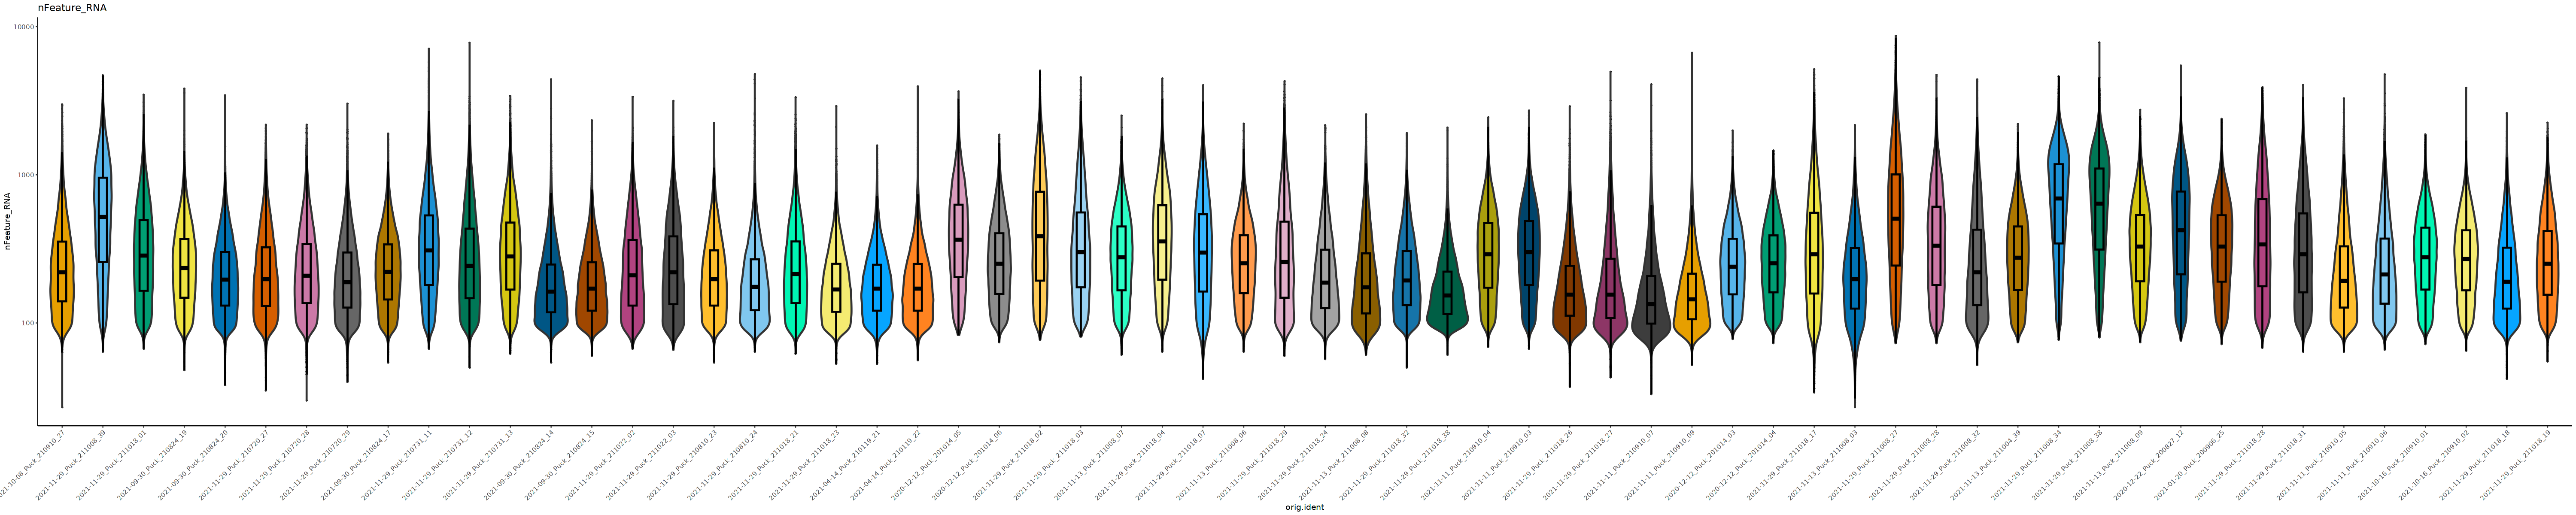

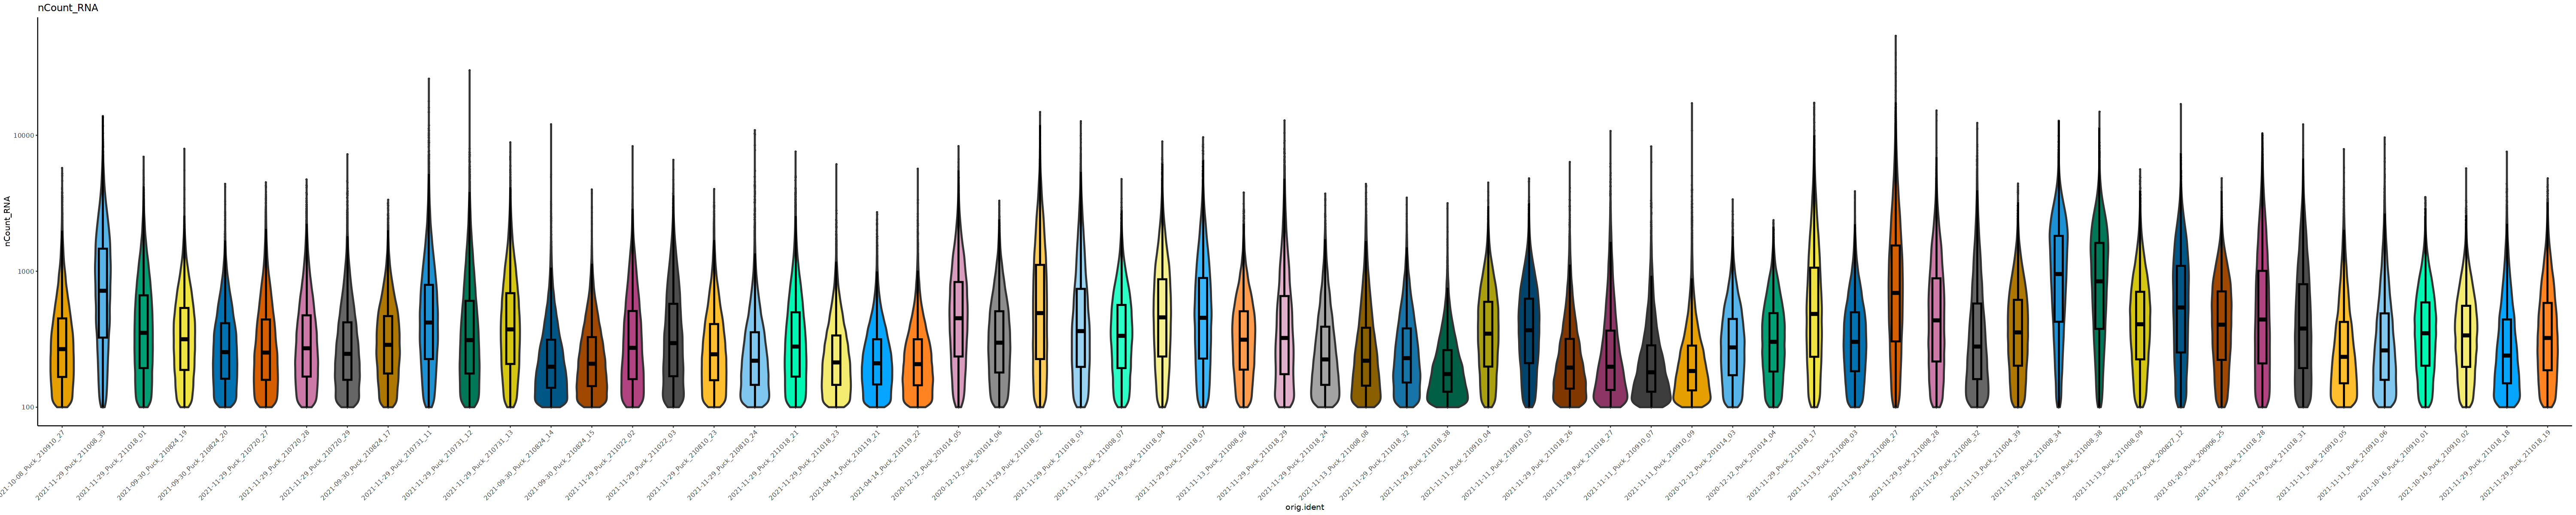

In [13]:
##Change order/levels 

Slideseq_combined$orig.ident <- factor(Slideseq_combined$orig.ident, levels = c(
    "2021-10-08_Puck_210910_27",
    "2021-11-29_Puck_211008_39",
    "2021-11-29_Puck_211018_01", 
    "2021-09-30_Puck_210824_19",
    "2021-09-30_Puck_210824_20",
    "2021-11-29_Puck_210720_27",
    "2021-11-29_Puck_210720_28",
    "2021-11-29_Puck_210720_29",
    "2021-09-30_Puck_210824_17",
    "2021-11-29_Puck_210731_11",
    "2021-11-29_Puck_210731_12",
    "2021-11-29_Puck_210731_13",
    "2021-09-30_Puck_210824_14",
    "2021-09-30_Puck_210824_15",
    "2021-11-29_Puck_211022_02",
    "2021-11-29_Puck_211022_03",
    "2021-11-29_Puck_210810_23",
    "2021-11-29_Puck_210810_24",
    "2021-11-29_Puck_211018_21",
    "2021-11-29_Puck_211018_23",
    "2021-04-14_Puck_210119_21",
    "2021-04-14_Puck_210119_22",
    "2020-12-12_Puck_201014_05",
    "2020-12-12_Puck_201014_06",
    "2021-11-29_Puck_211018_02",
    "2021-11-29_Puck_211018_03",
    "2021-11-13_Puck_211008_07",
    "2021-11-29_Puck_211018_04",
    "2021-11-29_Puck_211018_07",
    "2021-11-13_Puck_211008_06",
    "2021-11-29_Puck_211018_29",
    "2021-11-29_Puck_211018_24",
    "2021-11-13_Puck_211008_08",
    "2021-11-29_Puck_211018_32",
    "2021-11-29_Puck_211018_38",
    "2021-11-11_Puck_210910_04",
    "2021-11-11_Puck_210910_03",
    "2021-11-29_Puck_211018_26",
    "2021-11-29_Puck_211018_27",
    "2021-11-11_Puck_210910_07",
    "2021-11-11_Puck_210910_09",
    "2020-12-12_Puck_201014_03",
    "2020-12-12_Puck_201014_04",
    "2021-11-29_Puck_211018_17",
    "2021-11-13_Puck_211008_03",
    "2021-11-29_Puck_211008_27",
    "2021-11-29_Puck_211008_28",
    "2021-11-29_Puck_211008_32",
    "2021-11-13_Puck_211004_39",
    "2021-11-29_Puck_211008_34",
    "2021-11-29_Puck_211008_38",
    "2021-11-13_Puck_211008_09",
    "2020-12-22_Puck_200827_12",
    "2021-01-20_Puck_200906_25",
    "2021-11-29_Puck_211018_28",
    "2021-11-29_Puck_211018_31",
    "2021-11-11_Puck_210910_05",
    "2021-11-11_Puck_210910_06",
    "2021-10-16_Puck_210910_01",
    "2021-10-16_Puck_210910_02",
    "2021-11-29_Puck_211018_18",
    "2021-11-29_Puck_211018_19"))

dittoPlot(Slideseq_combined, "nFeature_RNA", group.by = "orig.ident", plots = c("jitter", "vlnplot", "boxplot"), legend.show = FALSE, do.raster = TRUE) + scale_y_log10()

ggsave("/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/nFeature_RNA_by_puck_ordered.pdf", width = 15, height = 5)

dittoPlot(Slideseq_combined, "nCount_RNA", group.by = "orig.ident", plots = c("jitter", "vlnplot", "boxplot"), legend.show = FALSE, do.raster = TRUE) + scale_y_log10()

ggsave("/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/nCount_RNA_by_puck_ordered.pdf", width = 15, height = 5)


In [4]:
##Cell type spatial plots 

##Modified function to plot all cell types 

plot_all_cell_types <- function(results_df, coords, cell_type_names) {
  barcodes = rownames(results_df[results_df$spot_class != "reject" & results_df$first_type %in% cell_type_names,])
  my_table = coords[barcodes,]
  my_table$class = results_df[barcodes,]$first_type
  n_levels = length(levels(my_table$class))
  #my_pal = pals::polychrome(15)[1:15]
  my_pal = c('#E69F00','#1C91D4','#F0E442','#0072B2','#666666','#CC79A7','#AD7700','#56B4E9','#009E73','#007756','#D5C711','#005685','#A04700','#D55E00')
  #my_pal = c('#5A5156','#E4E1E3','#F6222E','#FE00FA','#16FF32','#3283FE','#FEAF16','#B00068','#1CFFCE','#90AD1C','#2ED9FF','#DEA0FD','#AA0DFE','#F8A19F')
  pres = unique(as.integer(my_table$class))
  pres = pres[order(pres)]
  plot <- ggplot2::ggplot(my_table, ggplot2::aes(x=x, y=y)) + ggplot2::geom_point(ggplot2::aes(size = 0.5, shape=19,color=class)) +
    ggplot2::scale_color_manual(values = my_pal[pres])+ ggplot2::scale_shape_identity() + ggplot2::theme_classic() + ggplot2::scale_size_identity()
}


#Create plots of desired puck

i <- 2

plot_all_cell_types(results_df = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@results$results_df, coords = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@spatialRNA@coords, cell_type_names = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@cell_type_info$info[[2]])
ggsave("all_cell_types_H12_200.pdf", width = 10, height = 8)

i <- 24

plot_all_cell_types(results_df = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@results$results_df, coords = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@spatialRNA@coords, cell_type_names = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@cell_type_info$info[[2]])
ggsave("all_cell_types_28427.pdf", width = 10, height = 8)



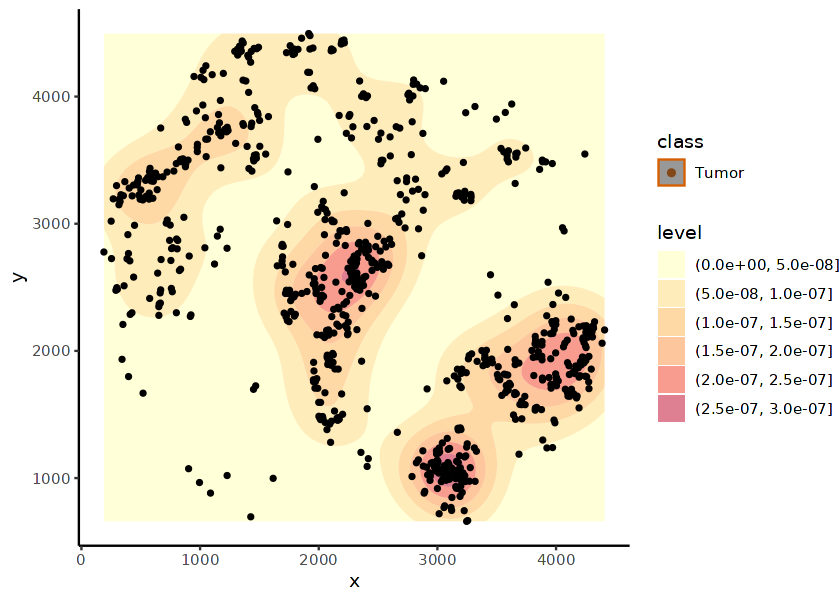

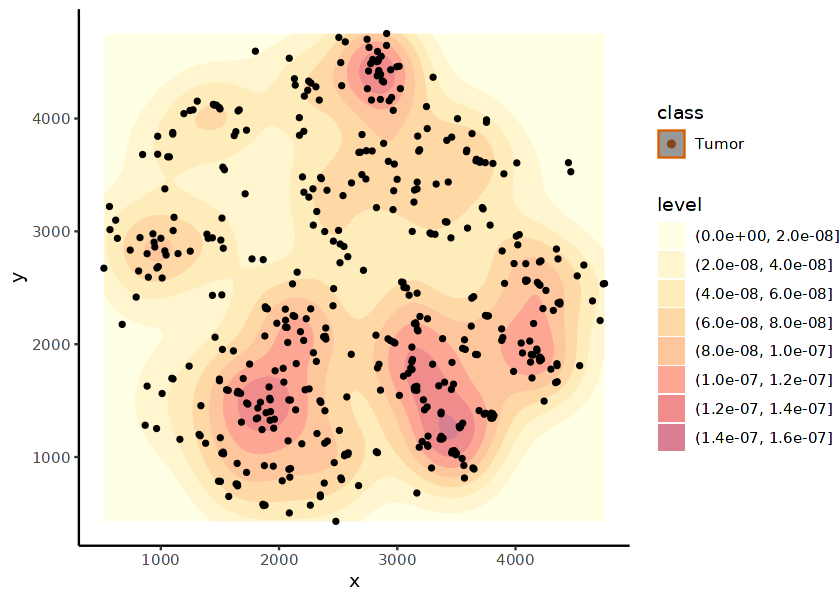

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette YlOrRd is 9
Returning the palette you asked for with that many colors
”


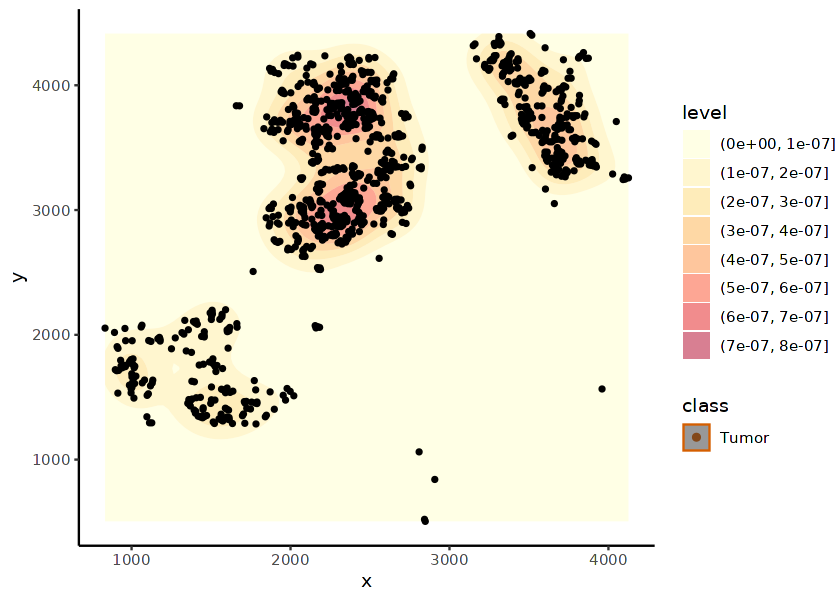

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette YlOrRd is 9
Returning the palette you asked for with that many colors
”


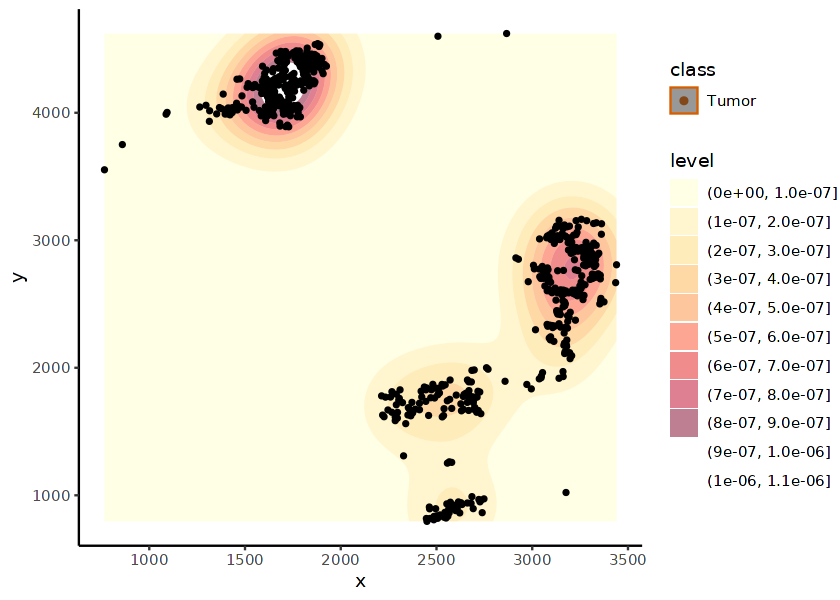

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette YlOrRd is 9
Returning the palette you asked for with that many colors
”


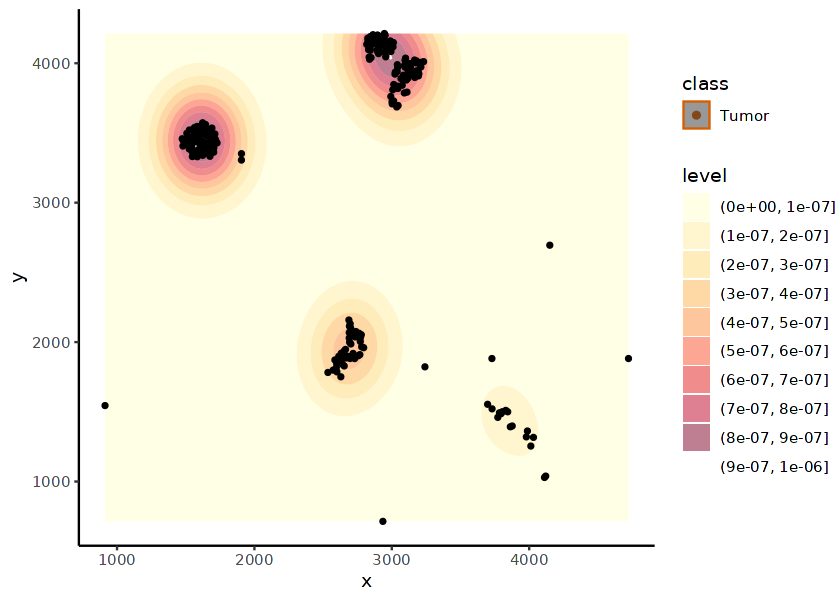

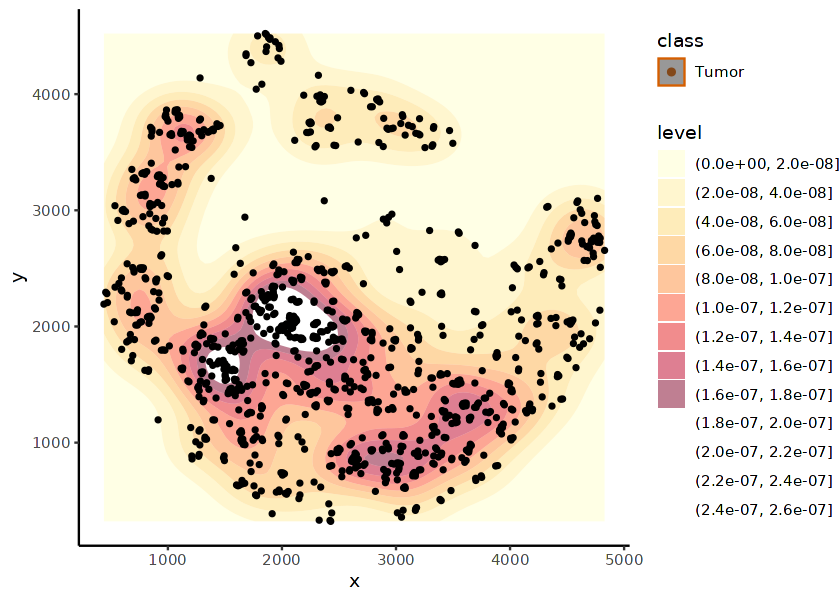

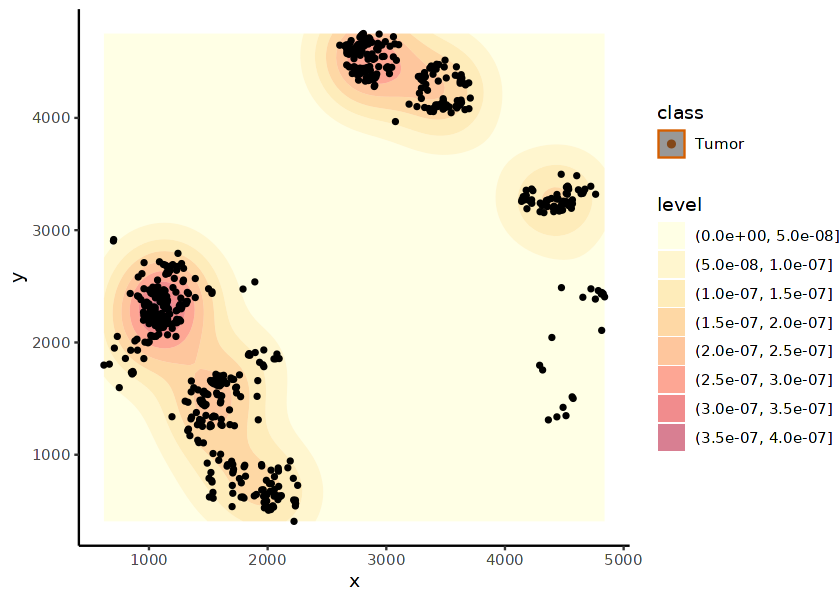

In [10]:
##Plot only tumor cells

options(repr.plot.width=7, repr.plot.height=5)

i <- 2

p <- plot_all_cell_types(results_df = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@results$results_df, coords = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@spatialRNA@coords, cell_type_names = 'Tumor')

p + geom_density_2d_filled(alpha = 0.5, adjust = 0.8) + 
  scale_fill_brewer(palette = 'YlOrRd') +
  geom_point(size = 1)
ggsave("tumor_cells_contour_H12_200.pdf", width = 10, height = 8)

options(repr.plot.width=7, repr.plot.height=5)

##Plot only tumor cells 

i <- 24

p <- plot_all_cell_types(results_df = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@results$results_df, coords = CHL.RCTD.combined.with.class@RCTD.reps[[i]]@spatialRNA@coords, cell_type_names = 'Tumor')

p + geom_density_2d_filled(alpha = 0.5, adjust = 0.8) + 
  scale_fill_brewer(palette = 'YlOrRd') +
  geom_point(size = 1)
ggsave("tumor_cells_contour_28427.pdf", width = 10, height = 8)

## Define spatial explanatory variables

In [3]:
## Load df with spatial metrics - candidate explanatory variables 

spatial_metrics <- read.csv("chl_df_with_metrics.csv")

extract_metric <- function(puck_ids, metric, metrics_df){
    exvar_list <- list()
    for (i in 1:length(puck_ids)){
    exvar_list[[i]] <- metrics_df %>% filter(puck_names == puck_ids[i]) %>% select(barcodes, metric) %>% deframe()
    }
    names(exvar_list) <- puck_ids
    return(exvar_list)
}

puck_ids_CHL <- c("2020-12-12_Puck_201014_03", "2020-12-12_Puck_201014_04", "2021-11-29_Puck_211018_32", "2021-11-29_Puck_211018_38", "2021-11-11_Puck_210910_04", "2021-11-11_Puck_210910_03", "2021-11-29_Puck_211018_28", "2021-11-29_Puck_211018_31", "2021-11-11_Puck_210910_05", "2021-11-11_Puck_210910_06", "2020-12-22_Puck_200827_12", "2021-01-20_Puck_200906_25", "2021-10-16_Puck_210910_01", "2021-10-16_Puck_210910_02", "2021-11-29_Puck_211018_18", "2021-11-29_Puck_211018_19", "2021-11-29_Puck_211018_26", "2021-11-29_Puck_211018_27", "2021-11-11_Puck_210910_07", "2021-11-11_Puck_210910_09", "2021-11-29_Puck_211018_29", "2021-11-29_Puck_211018_24", "2021-11-13_Puck_211008_08", "2021-11-29_Puck_211008_34", "2021-11-29_Puck_211008_38", "2021-11-13_Puck_211008_09", "2021-11-29_Puck_211018_04", "2021-11-29_Puck_211018_07", "2021-11-13_Puck_211008_06", "2021-11-29_Puck_211008_27", "2021-11-29_Puck_211008_28", "2021-11-29_Puck_211008_32", "2021-11-13_Puck_211004_39", "2021-11-29_Puck_211018_02", "2021-11-29_Puck_211018_03", "2021-11-13_Puck_211008_07", "2021-11-29_Puck_211018_17", "2021-11-13_Puck_211008_03")

proximity_exvar_list <- extract_metric(puck_ids = puck_ids_CHL, metric = "proximity_reversed", metrics_df = spatial_metrics)

force_200_exvar_list <- extract_metric(puck_ids = puck_ids_CHL, metric = "force_200", metrics_df = spatial_metrics)

density_normalized200_exvar_list <- extract_metric(puck_ids = puck_ids_CHL, metric = "density_normalized200", metrics_df = spatial_metrics)

general_force_exvar_list <- extract_metric(puck_ids = puck_ids_CHL, metric = "general_force", metrics_df = spatial_metrics)

## Save spatial metrics 

saveRDS(proximity_exvar_list, "proximity_exvar_list.rds")
saveRDS(density_normalized200_exvar_list, "density_normalized200.rds")

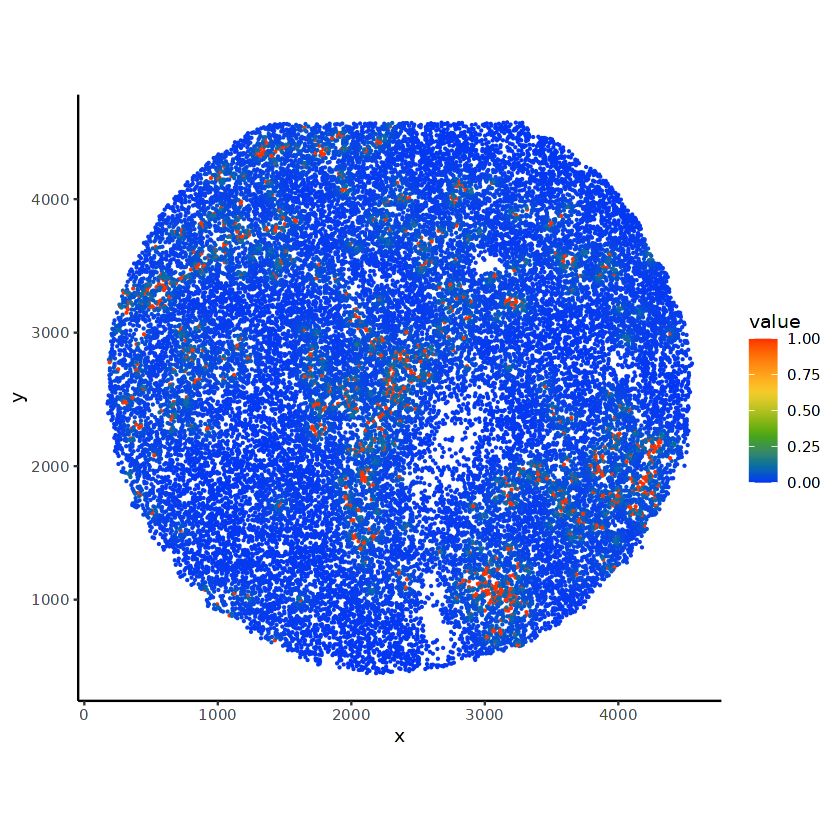

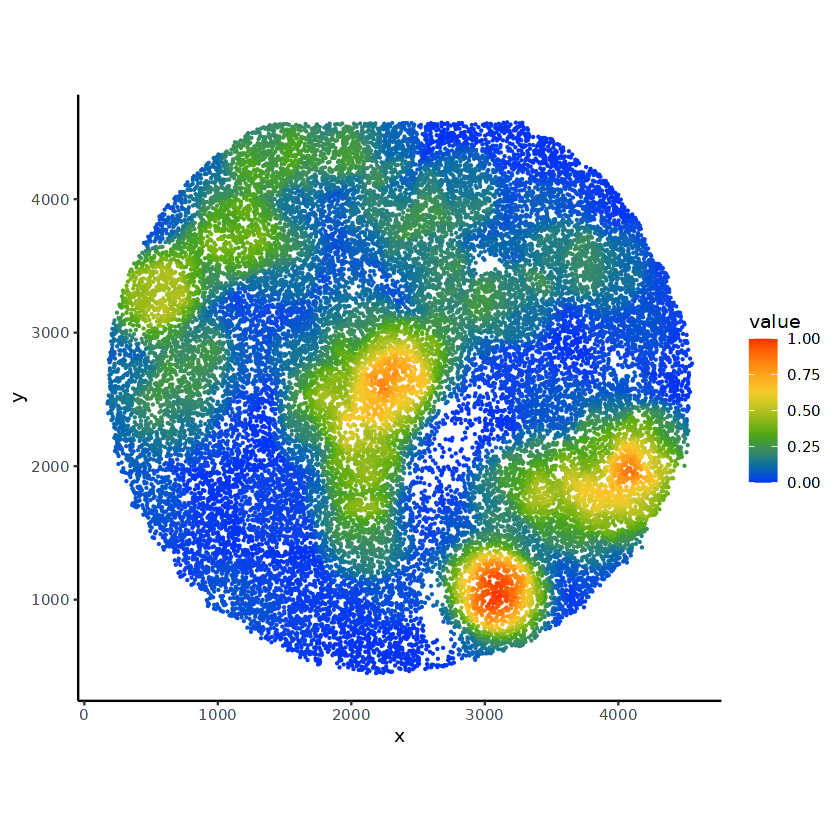

In [7]:
##Plot explanatory variables 

plot_puck_continuous(puck = CHL.RCTD.combined.with.class@RCTD.reps[[2]]@spatialRNA, barcodes = names(proximity_exvar_list[[2]]), plot_val = proximity_exvar_list[[2]])
plot_puck_continuous(puck = CHL.RCTD.combined.with.class@RCTD.reps[[2]]@spatialRNA, barcodes = names(density_normalized200_exvar_list[[2]]), plot_val = density_normalized200_exvar_list[[2]])

## Run cell type-specific inference of differential expression (C-SIDE)

In [43]:
## Run a loop to update spatialRNA objects 

for(i in 1:length(CHL.RCTD.combined.with.class@RCTD.reps)) {
  CHL.RCTD.combined.with.class@RCTD.reps[[i]]@spatialRNA <- spacexr:::coerce_old(CHL.RCTD.combined.with.class@RCTD.reps[[i]]@spatialRNA)
  CHL.RCTD.combined.with.class@RCTD.reps[[i]]@originalSpatialRNA <- spacexr:::coerce_old(CHL.RCTD.combined.with.class@RCTD.reps[[i]]@originalSpatialRNA)
  CHL.RCTD.combined.with.class@RCTD.reps[[i]]@config$max_cores <- 223
  CHL.RCTD.combined.with.class@RCTD.reps[[i]]@config$RCTDmode <- 'doublet'
}

cell_types <- CHL.RCTD.combined.with.class@RCTD.reps[[1]]@cell_type_info$info[[2]]
cell_types

##Run CSIDE using the density and proximity explanatory variables 

CHL_RCTD_combined_with_class_exvar_density_new_low_gene_threshold <- run.CSIDE.replicates(RCTD.replicates = CHL.RCTD.combined.with.class, explanatory.variable.replicates = density_normalized200_exvar_list, cell_types = cell_types, population_de = F, gene_threshold = 1e-06, cell_type_threshold = 0)
CHL_RCTD_combined_with_class_exvar_proximity_new_low_gene_threshold <- run.CSIDE.replicates(RCTD.replicates = CHL.RCTD.combined.with.class, explanatory.variable.replicates = proximity_exvar_list, cell_types = cell_types, population_de = F, gene_threshold = 1e-06, cell_type_threshold = 0)


[1] "B_cells"      "BEC"          "CD4_T_cells"  "CD8_T_cells"  "FDC"         
 [6] "Fibroblasts"  "LEC"          "Macrophages"  "mDC"          "Monocytes"   
[11] "NK_cells"     "pDC"          "Plasma_cells" "Tumor"

In [2]:
##Load resulting objects 

system(paste0("gsutil -m cp gs://lymphoma-slideseq-data-broad/results/processed_slideseq_data/CSIDE_ALL/CHL_RCTD_combined_with_class_exvar_density_new_ref_low_gene_threshold.rds /home/vshanmug/data/091322_RCTD_CSIDE_repeat_new_ref"))
system(paste0("gsutil -m cp gs://lymphoma-slideseq-data-broad/results/processed_slideseq_data/CSIDE_ALL/CHL_RCTD_combined_with_class_exvar_proximity_low_gene_threshold.rds /home/vshanmug/data/091322_RCTD_CSIDE_repeat_new_ref"))

RCTD_reps_density <- readRDS("/home/vshanmug/data/091322_RCTD_CSIDE_repeat_new_ref/CHL_RCTD_combined_with_class_exvar_density_new_ref_low_gene_threshold.rds")
RCTD_reps_proximity <- readRDS("/home/vshanmug/data/091322_RCTD_CSIDE_repeat_new_ref/CHL_RCTD_combined_with_class_exvar_proximity_low_gene_threshold.rds")

## Run population-level differential expression analysis (on all replicates and samples)

In [30]:
RCTD_reps_density <- CSIDE.population.inference(RCTD_reps_density, use.groups = TRUE, MIN.CONV.GROUPS = 3, log_fc_thresh = 0.5*log(2), q_thresh = 0.05, CT.PROP = 0.25)


CSIDE.population.inference: running population DE inference with use.groups=TRUE



[1] "one_ct_genes: population inference on cell type, B_cells"


get_de_pop: testing gene, DNAJA2 , of index: 1000

get_de_pop: testing gene, MAN2B1 , of index: 2000

get_de_pop: testing gene, RBM7 , of index: 3000

get_de_pop: testing gene, UGDH , of index: 4000

get_de_pop: testing gene, GOLGA8B , of index: 5000

get_de_pop: testing gene, ZNF106 , of index: 6000

get_de_pop: testing gene, NONO , of index: 7000

get_de_pop: testing gene, CCPG1 , of index: 8000

get_de_pop: testing gene, UNC5CL , of index: 9000

get_de_pop: testing gene, AC015522.1 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, BEC"


get_de_pop: testing gene, DNAJC17 , of index: 1000

get_de_pop: testing gene, LPAR6 , of index: 2000

get_de_pop: testing gene, PTPRG , of index: 3000

get_de_pop: testing gene, TRIM33 , of index: 4000

get_de_pop: testing gene, CRAT , of index: 5000

get_de_pop: testing gene, RRM2B , of index: 6000

get_de_pop: testing gene, GOLGA2 , of index: 7000

get_de_pop: testing gene, AP001273.2 , of index: 8000

get_de_pop: testing gene, XPO4 , of index: 9000

get_de_pop: testing gene, TNNT1 , of index: 10000

get_de_pop: testing gene, AC005746.2 , of index: 11000



[1] "done"
[1] "one_ct_genes: population inference on cell type, CD4_T_cells"


get_de_pop: testing gene, CCDC142 , of index: 1000

get_de_pop: testing gene, ELMOD3 , of index: 2000

get_de_pop: testing gene, IL2RG , of index: 3000

get_de_pop: testing gene, MVD , of index: 4000

get_de_pop: testing gene, PRMT2 , of index: 5000

get_de_pop: testing gene, SMIM4 , of index: 6000

get_de_pop: testing gene, TYW5 , of index: 7000

get_de_pop: testing gene, ITIH2 , of index: 8000

get_de_pop: testing gene, ZFP41 , of index: 9000

get_de_pop: testing gene, AC003682.1 , of index: 10000

get_de_pop: testing gene, AF131215.7 , of index: 11000



[1] "done"
[1] "one_ct_genes: population inference on cell type, CD8_T_cells"


get_de_pop: testing gene, COPS4 , of index: 1000

get_de_pop: testing gene, HCG18 , of index: 2000

get_de_pop: testing gene, NDFIP1 , of index: 3000

get_de_pop: testing gene, RNF216 , of index: 4000

get_de_pop: testing gene, TRANK1 , of index: 5000

get_de_pop: testing gene, CORO7 , of index: 6000

get_de_pop: testing gene, HENMT1 , of index: 7000

get_de_pop: testing gene, HIP1R , of index: 8000

get_de_pop: testing gene, SYCE1 , of index: 9000

get_de_pop: testing gene, AC018761.2 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, FDC"


get_de_pop: testing gene, COL18A1 , of index: 1000

get_de_pop: testing gene, GRAMD1A , of index: 2000

get_de_pop: testing gene, MSH3 , of index: 3000

get_de_pop: testing gene, RAB5C , of index: 4000

get_de_pop: testing gene, TIMP1 , of index: 5000

get_de_pop: testing gene, AAMDC , of index: 6000

get_de_pop: testing gene, PPP2R5D , of index: 7000

get_de_pop: testing gene, LNPK , of index: 8000

get_de_pop: testing gene, LINC01483 , of index: 9000

get_de_pop: testing gene, AC010997.3 , of index: 10000

get_de_pop: testing gene, CCL25 , of index: 11000

get_de_pop: testing gene, CELA2A , of index: 12000



[1] "done"
[1] "one_ct_genes: population inference on cell type, Fibroblasts"


get_de_pop: testing gene, CDK10 , of index: 1000

get_de_pop: testing gene, FAM189A1 , of index: 2000

get_de_pop: testing gene, KLHL21 , of index: 3000

get_de_pop: testing gene, NUCKS1 , of index: 4000

get_de_pop: testing gene, RIOK3 , of index: 5000

get_de_pop: testing gene, THRA , of index: 6000

get_de_pop: testing gene, ZNF384 , of index: 7000

get_de_pop: testing gene, SLC35B4 , of index: 8000

get_de_pop: testing gene, AC072061.1 , of index: 9000

get_de_pop: testing gene, NHLRC1 , of index: 10000

get_de_pop: testing gene, CERS3-AS1 , of index: 11000

get_de_pop: testing gene, CPEB1-AS1 , of index: 12000



[1] "done"
[1] "one_ct_genes: population inference on cell type, LEC"


get_de_pop: testing gene, ETFB , of index: 1000

get_de_pop: testing gene, NEK5 , of index: 2000

get_de_pop: testing gene, SSH2 , of index: 3000

get_de_pop: testing gene, BTBD10 , of index: 4000

get_de_pop: testing gene, PAK1IP1 , of index: 5000

get_de_pop: testing gene, AC073529.1 , of index: 6000

get_de_pop: testing gene, CISD1 , of index: 7000

get_de_pop: testing gene, TANGO6 , of index: 8000

get_de_pop: testing gene, AC005363.2 , of index: 9000

get_de_pop: testing gene, AC018697.1 , of index: 10000

get_de_pop: testing gene, SAXO2 , of index: 11000



[1] "done"
[1] "one_ct_genes: population inference on cell type, Macrophages"


get_de_pop: testing gene, CBWD5 , of index: 1000

get_de_pop: testing gene, EHD4 , of index: 2000

get_de_pop: testing gene, HSP90B1 , of index: 3000

get_de_pop: testing gene, MRPS15 , of index: 4000

get_de_pop: testing gene, PPFIA4 , of index: 5000

get_de_pop: testing gene, SLC22A23 , of index: 6000

get_de_pop: testing gene, TRIM38 , of index: 7000

get_de_pop: testing gene, ZNF804A , of index: 8000

get_de_pop: testing gene, LACTB2-AS1 , of index: 9000

get_de_pop: testing gene, TSPAN10 , of index: 10000

get_de_pop: testing gene, LRRN1 , of index: 11000



[1] "done"
[1] "one_ct_genes: population inference on cell type, mDC"


get_de_pop: testing gene, CCDC146 , of index: 1000

get_de_pop: testing gene, EIF3L , of index: 2000

get_de_pop: testing gene, IDH1 , of index: 3000

get_de_pop: testing gene, MS4A6A , of index: 4000

get_de_pop: testing gene, PPP1R11 , of index: 5000

get_de_pop: testing gene, SLC35D2 , of index: 6000

get_de_pop: testing gene, TSR2 , of index: 7000

get_de_pop: testing gene, BCL2L2 , of index: 8000

get_de_pop: testing gene, MRGBP , of index: 9000

get_de_pop: testing gene, BCO1 , of index: 10000

get_de_pop: testing gene, AC005479.2 , of index: 11000



[1] "done"
[1] "one_ct_genes: population inference on cell type, Monocytes"


get_de_pop: testing gene, CISD2 , of index: 1000

get_de_pop: testing gene, GCC1 , of index: 2000

get_de_pop: testing gene, MED20 , of index: 3000

get_de_pop: testing gene, PPP1R7 , of index: 4000

get_de_pop: testing gene, SPINT2 , of index: 5000

get_de_pop: testing gene, YEATS2 , of index: 6000

get_de_pop: testing gene, AC006460.1 , of index: 7000

get_de_pop: testing gene, OSGIN1 , of index: 8000

get_de_pop: testing gene, IL12A-AS1 , of index: 9000



[1] "done"
[1] "one_ct_genes: population inference on cell type, NK_cells"


get_de_pop: testing gene, FBF1 , of index: 1000

get_de_pop: testing gene, PAK4 , of index: 2000

get_de_pop: testing gene, TNFSF9 , of index: 3000

get_de_pop: testing gene, EMC3 , of index: 4000

get_de_pop: testing gene, SLC12A8 , of index: 5000

get_de_pop: testing gene, RIOX1 , of index: 6000

get_de_pop: testing gene, C10orf143 , of index: 7000

get_de_pop: testing gene, UBA6-AS1 , of index: 8000

get_de_pop: testing gene, LINC01871 , of index: 9000

get_de_pop: testing gene, USP6 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, pDC"


get_de_pop: testing gene, GPKOW , of index: 1000

get_de_pop: testing gene, RAB8A , of index: 2000

get_de_pop: testing gene, ZNF783 , of index: 3000

get_de_pop: testing gene, LTBP3 , of index: 4000

get_de_pop: testing gene, UPF3A , of index: 5000

get_de_pop: testing gene, KMT5B , of index: 6000

get_de_pop: testing gene, NUDCD1 , of index: 7000

get_de_pop: testing gene, SCLT1 , of index: 8000

get_de_pop: testing gene, TRPM1 , of index: 9000

get_de_pop: testing gene, ASB16 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, Plasma_cells"


get_de_pop: testing gene, FBXO38 , of index: 1000

get_de_pop: testing gene, PDCL , of index: 2000

get_de_pop: testing gene, TTC19 , of index: 3000

get_de_pop: testing gene, GPR107 , of index: 4000

get_de_pop: testing gene, UBE2B , of index: 5000

get_de_pop: testing gene, DCAF16 , of index: 6000

get_de_pop: testing gene, JSRP1 , of index: 7000

get_de_pop: testing gene, LINC02356 , of index: 8000

get_de_pop: testing gene, UTP20 , of index: 9000

get_de_pop: testing gene, LINC01099 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, Tumor"


get_de_pop: testing gene, CCDC85B , of index: 1000

get_de_pop: testing gene, ENKD1 , of index: 2000

get_de_pop: testing gene, IQCB1 , of index: 3000

get_de_pop: testing gene, NANS , of index: 4000

get_de_pop: testing gene, PSMC4 , of index: 5000

get_de_pop: testing gene, SNRNP40 , of index: 6000

get_de_pop: testing gene, UCK1 , of index: 7000

get_de_pop: testing gene, KLC4 , of index: 8000

get_de_pop: testing gene, TMBIM4 , of index: 9000

get_de_pop: testing gene, ARIH2OS , of index: 10000

get_de_pop: testing gene, PAX7 , of index: 11000

get_de_pop: testing gene, LINC02505 , of index: 12000

get_de_pop: testing gene, AC020743.2 , of index: 13000



[1] "done"


In [175]:
RCTD_reps_proximity <- CSIDE.population.inference(RCTD_reps_proximity, use.groups = TRUE, MIN.CONV.GROUPS = 3, log_fc_thresh = 0.5*log(2), q_thresh = 0.05, CT.PROP = 0.25)


CSIDE.population.inference: running population DE inference with use.groups=TRUE



[1] "one_ct_genes: population inference on cell type, B_cells"


get_de_pop: testing gene, CNPPD1 , of index: 1000

get_de_pop: testing gene, GYS1 , of index: 2000

get_de_pop: testing gene, NADK , of index: 3000

get_de_pop: testing gene, RGS19 , of index: 4000

get_de_pop: testing gene, TMEM43 , of index: 5000

get_de_pop: testing gene, BLOC1S2 , of index: 6000

get_de_pop: testing gene, AC016831.6 , of index: 7000

get_de_pop: testing gene, TMEM263 , of index: 8000

get_de_pop: testing gene, AC004053.1 , of index: 9000

get_de_pop: testing gene, KLHL11 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, BEC"


get_de_pop: testing gene, FAT3 , of index: 1000

get_de_pop: testing gene, OSGIN1 , of index: 2000

get_de_pop: testing gene, TRAK1 , of index: 3000

get_de_pop: testing gene, CPNE8 , of index: 4000

get_de_pop: testing gene, NUDCD2 , of index: 5000

get_de_pop: testing gene, UMPS , of index: 6000

get_de_pop: testing gene, NMD3 , of index: 7000

get_de_pop: testing gene, CYTH1 , of index: 8000

get_de_pop: testing gene, SULF2 , of index: 9000

get_de_pop: testing gene, MRPL28 , of index: 10000

get_de_pop: testing gene, AC123768.2 , of index: 11000



[1] "done"
[1] "one_ct_genes: population inference on cell type, CD4_T_cells"


get_de_pop: testing gene, CDK12 , of index: 1000

get_de_pop: testing gene, FBLN7 , of index: 2000

get_de_pop: testing gene, LLPH , of index: 3000

get_de_pop: testing gene, PCYT1A , of index: 4000

get_de_pop: testing gene, SEC23IP , of index: 5000

get_de_pop: testing gene, TRAV20 , of index: 6000

get_de_pop: testing gene, CASC1 , of index: 7000

get_de_pop: testing gene, PIWIL2 , of index: 8000

get_de_pop: testing gene, Z84492.1 , of index: 9000

get_de_pop: testing gene, CASC16 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, CD8_T_cells"


get_de_pop: testing gene, DDX55 , of index: 1000

get_de_pop: testing gene, L3MBTL3 , of index: 2000

get_de_pop: testing gene, PRPF18 , of index: 3000

get_de_pop: testing gene, TMEM11 , of index: 4000

get_de_pop: testing gene, COPS4 , of index: 5000

get_de_pop: testing gene, TTN-AS1 , of index: 6000

get_de_pop: testing gene, UPK2 , of index: 7000

get_de_pop: testing gene, ZC3H14 , of index: 8000

get_de_pop: testing gene, HSD17B1 , of index: 9000

get_de_pop: testing gene, BX649632.1 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, FDC"


get_de_pop: testing gene, CPNE1 , of index: 1000

get_de_pop: testing gene, HMGCR , of index: 2000

get_de_pop: testing gene, NKRF , of index: 3000

get_de_pop: testing gene, SCAF1 , of index: 4000

get_de_pop: testing gene, UBXN6 , of index: 5000

get_de_pop: testing gene, FAM207A , of index: 6000

get_de_pop: testing gene, UTP18 , of index: 7000

get_de_pop: testing gene, TTLL4 , of index: 8000

get_de_pop: testing gene, AC107973.1 , of index: 9000

get_de_pop: testing gene, MIR497HG , of index: 10000

get_de_pop: testing gene, AF123462.1 , of index: 11000

get_de_pop: testing gene, AP001462.1 , of index: 12000



[1] "done"
[1] "one_ct_genes: population inference on cell type, Fibroblasts"


get_de_pop: testing gene, COL4A2 , of index: 1000

get_de_pop: testing gene, GTF2E1 , of index: 2000

get_de_pop: testing gene, MYO1B , of index: 3000

get_de_pop: testing gene, RCN2 , of index: 4000

get_de_pop: testing gene, TNFRSF1A , of index: 5000

get_de_pop: testing gene, CAPN1 , of index: 6000

get_de_pop: testing gene, SLC27A1 , of index: 7000

get_de_pop: testing gene, NGB , of index: 8000

get_de_pop: testing gene, TMEM64 , of index: 9000

get_de_pop: testing gene, PRRG3 , of index: 10000

get_de_pop: testing gene, CDH9 , of index: 11000

get_de_pop: testing gene, BEST3 , of index: 12000



[1] "done"
[1] "one_ct_genes: population inference on cell type, LEC"


get_de_pop: testing gene, DLD , of index: 1000

get_de_pop: testing gene, LINC01035 , of index: 2000

get_de_pop: testing gene, PSMD8 , of index: 3000

get_de_pop: testing gene, TRAPPC5 , of index: 4000

get_de_pop: testing gene, CREBZF , of index: 5000

get_de_pop: testing gene, RFWD3 , of index: 6000

get_de_pop: testing gene, C21orf91 , of index: 7000

get_de_pop: testing gene, TMEM263 , of index: 8000

get_de_pop: testing gene, AC024563.1 , of index: 9000

get_de_pop: testing gene, IQCM , of index: 10000

get_de_pop: testing gene, AC140125.2 , of index: 11000



[1] "done"
[1] "one_ct_genes: population inference on cell type, Macrophages"


get_de_pop: testing gene, CDAN1 , of index: 1000

get_de_pop: testing gene, FAM189B , of index: 2000

get_de_pop: testing gene, KRBOX4 , of index: 3000

get_de_pop: testing gene, OSBP , of index: 4000

get_de_pop: testing gene, RRAS , of index: 5000

get_de_pop: testing gene, TMEM220 , of index: 6000

get_de_pop: testing gene, ZNF684 , of index: 7000

get_de_pop: testing gene, CRYBG3 , of index: 8000

get_de_pop: testing gene, LILRA6 , of index: 9000

get_de_pop: testing gene, C21orf2 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, mDC"


get_de_pop: testing gene, CENPL , of index: 1000

get_de_pop: testing gene, FBXO9 , of index: 2000

get_de_pop: testing gene, LONP1 , of index: 3000

get_de_pop: testing gene, PDE4DIP , of index: 4000

get_de_pop: testing gene, SERINC3 , of index: 5000

get_de_pop: testing gene, TSC22D4 , of index: 6000

get_de_pop: testing gene, EFCAB3 , of index: 7000

get_de_pop: testing gene, LINC01362 , of index: 8000

get_de_pop: testing gene, TLDC2 , of index: 9000

get_de_pop: testing gene, RGS20 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, Monocytes"


get_de_pop: testing gene, CPPED1 , of index: 1000

get_de_pop: testing gene, NFKBIE , of index: 3000

get_de_pop: testing gene, RTN3 , of index: 4000

get_de_pop: testing gene, TUBD1 , of index: 5000

get_de_pop: testing gene, KCNK13 , of index: 6000

get_de_pop: testing gene, TYW1B , of index: 7000

get_de_pop: testing gene, BCKDHA , of index: 8000

get_de_pop: testing gene, AC068875.1 , of index: 9000



[1] "done"
[1] "one_ct_genes: population inference on cell type, NK_cells"


get_de_pop: testing gene, CRADD , of index: 1000

get_de_pop: testing gene, HSPA1L , of index: 2000

get_de_pop: testing gene, OFD1 , of index: 3000

get_de_pop: testing gene, SLC26A2 , of index: 4000

get_de_pop: testing gene, YPEL3 , of index: 5000

get_de_pop: testing gene, IWS1 , of index: 6000

get_de_pop: testing gene, ZKSCAN1 , of index: 7000

get_de_pop: testing gene, ZNF26 , of index: 8000

get_de_pop: testing gene, ZNF585B , of index: 9000

get_de_pop: testing gene, AC005944.1 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, pDC"


get_de_pop: testing gene, CRELD1 , of index: 1000

get_de_pop: testing gene, HSCB , of index: 2000

get_de_pop: testing gene, NUP133 , of index: 3000

get_de_pop: testing gene, SIDT1 , of index: 4000

get_de_pop: testing gene, VSTM1 , of index: 5000

get_de_pop: testing gene, IRF4 , of index: 6000

get_de_pop: testing gene, AC135050.3 , of index: 7000

get_de_pop: testing gene, AC004076.1 , of index: 8000

get_de_pop: testing gene, RIPOR2 , of index: 9000

get_de_pop: testing gene, AL356417.1 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, Plasma_cells"


get_de_pop: testing gene, COA6 , of index: 1000

get_de_pop: testing gene, HAUS1 , of index: 2000

get_de_pop: testing gene, NAPEPLD , of index: 3000

get_de_pop: testing gene, RNF114 , of index: 4000

get_de_pop: testing gene, TRANK1 , of index: 5000

get_de_pop: testing gene, CIZ1 , of index: 6000

get_de_pop: testing gene, ZNF92 , of index: 7000

get_de_pop: testing gene, ABHD15-AS1 , of index: 8000

get_de_pop: testing gene, PCNX3 , of index: 9000

get_de_pop: testing gene, AC073641.1 , of index: 10000



[1] "done"
[1] "one_ct_genes: population inference on cell type, Tumor"


get_de_pop: testing gene, CCAR2 , of index: 1000

get_de_pop: testing gene, EHBP1 , of index: 2000

get_de_pop: testing gene, HYLS1 , of index: 3000

get_de_pop: testing gene, MRPL2 , of index: 4000

get_de_pop: testing gene, POGK , of index: 5000

get_de_pop: testing gene, SETMAR , of index: 6000

get_de_pop: testing gene, TNK1 , of index: 7000

get_de_pop: testing gene, ZNF706 , of index: 8000

get_de_pop: testing gene, AC020551.1 , of index: 9000

get_de_pop: testing gene, CTH , of index: 10000

get_de_pop: testing gene, SLC9A2 , of index: 11000

get_de_pop: testing gene, AF129408.1 , of index: 12000

get_de_pop: testing gene, TMEM52B , of index: 13000



[1] "done"


In [176]:
saveRDS(RCTD_reps_density, "/home/vshanmug/data/091322_RCTD_CSIDE_repeat_new_ref/CHL_RCTD_combined_with_class_exvar_density_new_ref_low_gene_threshold.rds")
saveRDS(RCTD_reps_proximity, "/home/vshanmug/data/091322_RCTD_CSIDE_repeat_new_ref/CHL_RCTD_combined_with_class_exvar_proximity_low_gene_threshold.rds")

## Visualization of results

In [3]:
##Function to plot a given gene in two regions (tumor cell dense and sparse or proximial and distal)

plot_gene_two_regions <- function(myRCTD, gene, cell_type, min_UMI = 100, expr.thresh = 0, exvar_thresh = 0.5) {
  puck <- myRCTD@originalSpatialRNA
  barcodes <- myRCTD@internal_vars_de$barcodes
  my_beta <- myRCTD@internal_vars_de$my_beta
  X2 <- myRCTD@internal_vars_de$X2
  sig_gene_df <- myRCTD@de_results$sig_gene_list[[cell_type]]
  barcodes_sing <- names(which(my_beta[barcodes,cell_type] > 0.999))
  MULT = 500
  barc_plot <- intersect(barcodes_sing,colnames(puck@counts)[puck@nUMI >= min_UMI])
  Y_plot <- MULT*puck@counts[gene,]/puck@nUMI
  #my_title = paste(gene,": log_fc=",round(myRCTD@de_results$gene_fits$mean_val[gene,cell_type],2))
  my_class <- rep(0,length(barc_plot)); names(my_class) <- barc_plot
  my_class[(X2[barc_plot,2] <= exvar_thresh) & (Y_plot[barc_plot] == expr.thresh)] <- 1
  my_class[(X2[barc_plot,2] <= exvar_thresh) & (Y_plot[barc_plot] > expr.thresh)] <- 3
  my_class[(X2[barc_plot,2] > exvar_thresh) & (Y_plot[barc_plot] == expr.thresh)] <- 2
  my_class[(X2[barc_plot,2] > exvar_thresh) & (Y_plot[barc_plot] > expr.thresh)] <- 4
  p3 <- plot_class(puck, barc_plot[order(my_class[barc_plot])], factor(my_class))
  suppressMessages(p3 <- p3 + scale_color_manual(values=c("#CCE2EF","#F6DECC","#0072B2","#D55E00")) + ggtitle(gene))
  return(p3)
}

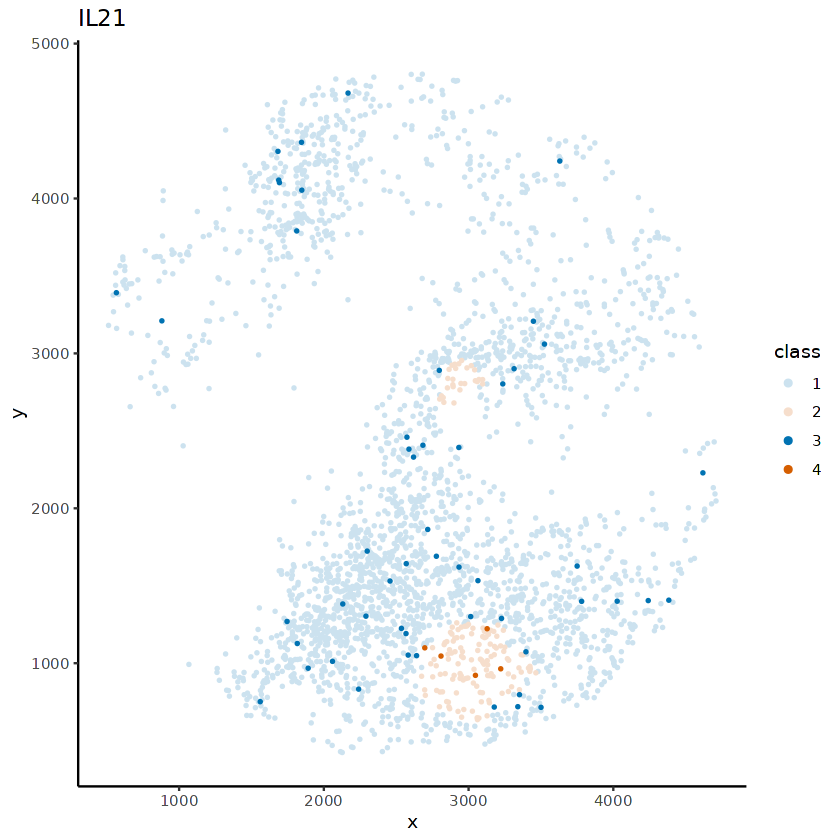

In [8]:
plot_gene_two_regions(myRCTD = RCTD_reps_density@RCTD.reps[[26]], gene = "IL21", cell_type = "CD4_T_cells")

ggsave("/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/IL21_CD4_T_cells_puck26_spatial_plot.pdf", width = 5, height = 5)


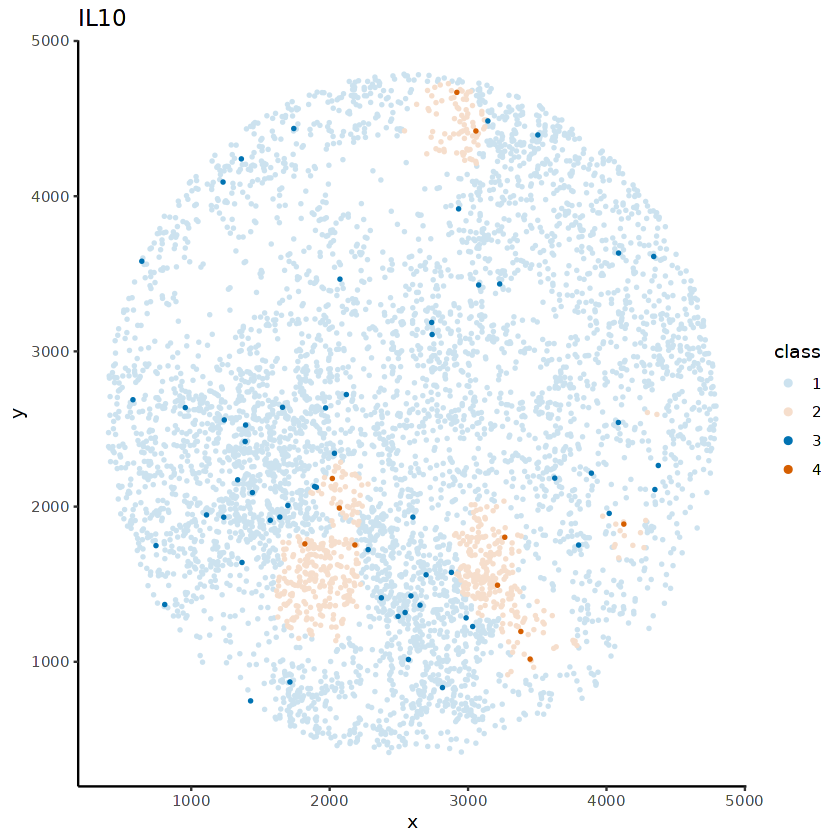

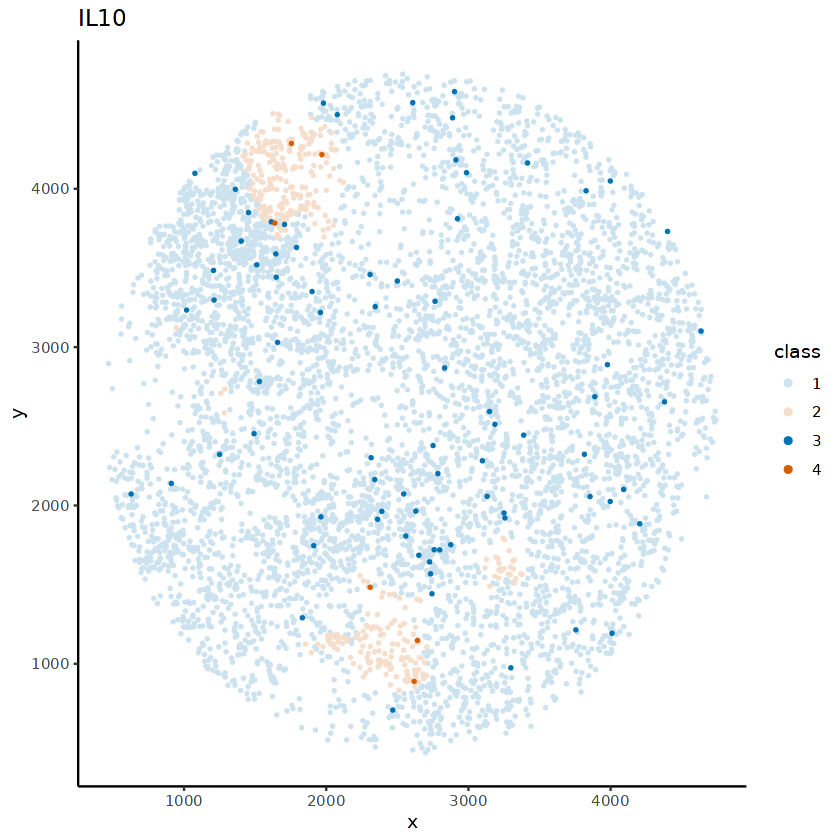

In [9]:
plot_gene_two_regions(myRCTD = RCTD_reps_density@RCTD.reps[[24]], gene = "IL10", cell_type = "Macrophages")

ggsave("/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/IL10_Macrophages_puck24_spatial_plot.pdf", width = 5, height = 5)

plot_gene_two_regions(myRCTD = RCTD_reps_density@RCTD.reps[[25]], gene = "IL10", cell_type = "Macrophages")

ggsave("/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/IL10_Macrophages_puck25_spatial_plot.pdf", width = 5, height = 5)


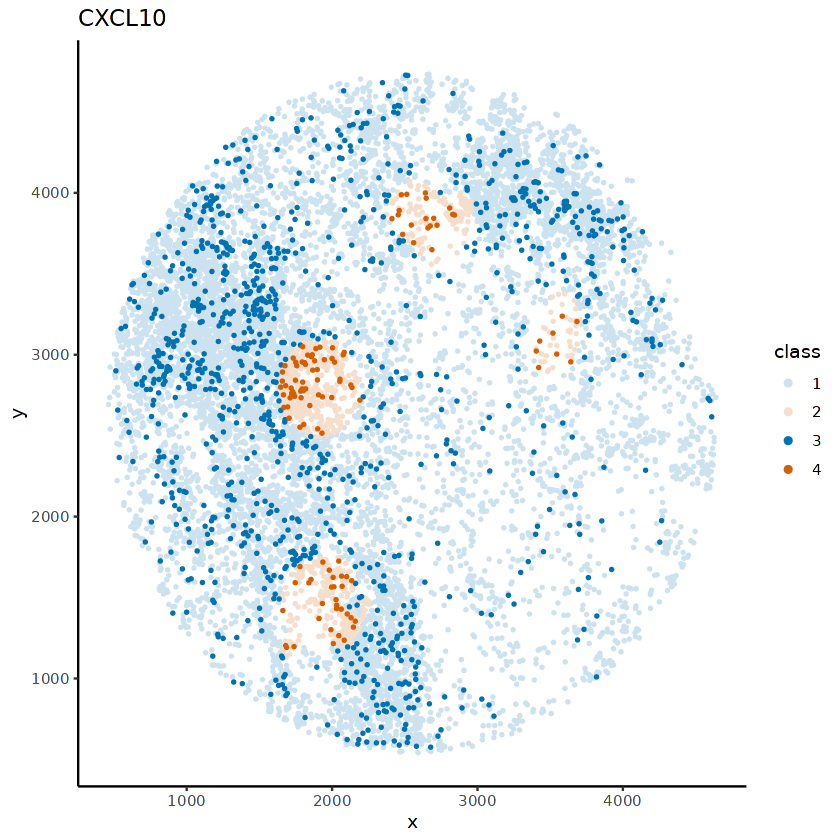

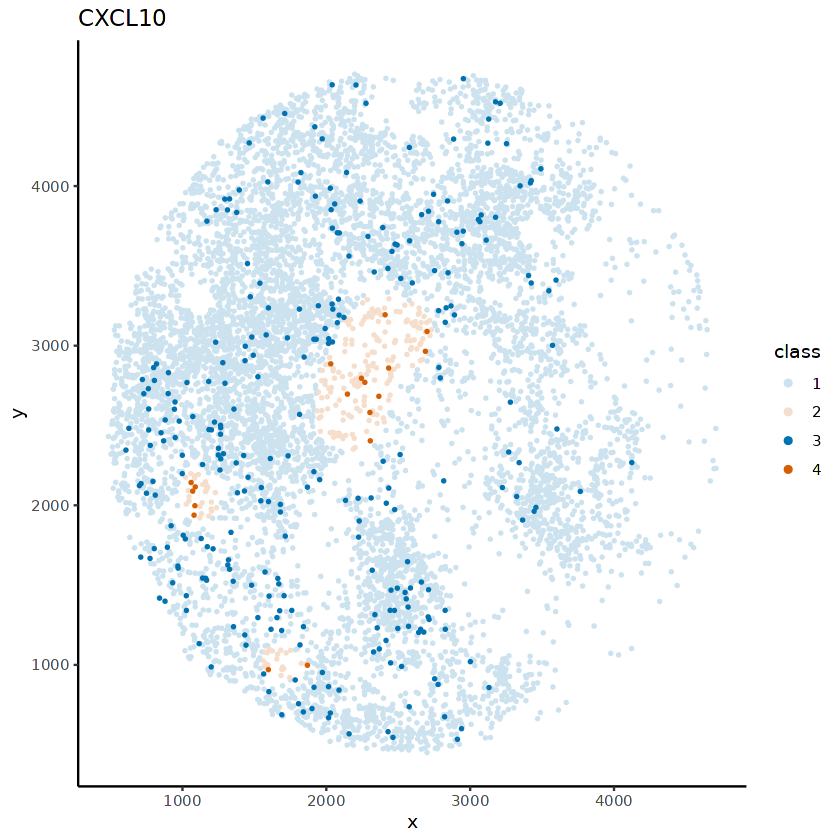

In [10]:
plot_gene_two_regions(myRCTD = RCTD_reps_density@RCTD.reps[[6]], gene = "CXCL10", cell_type = "Macrophages")

ggsave("/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/CXCL10_Macrophages_puck6_spatial_plot.pdf", width = 5, height = 5)

plot_gene_two_regions(myRCTD = RCTD_reps_density@RCTD.reps[[7]], gene = "CXCL10", cell_type = "Macrophages")

ggsave("/home/vshanmug/results/091322_RCTD_CSIDE_repeat_new_ref/CXCL10_Macrophages_puck7_spatial_plot.pdf", width = 5, height = 5)
